$(0,1)$ differences may occur for instances with $10.2 < LSTAT < 19.2, ZN < 6, CRIM<7, AGE≥1$
- Differences: $11.1 ≤ LSTAT < 18.8, ZN=0$ (13 instances)
- CF: $CRIM≥7 \rightarrow (0,0)$
- L: $10.3 < LSTAT$
    - CF: $LSTAT≤10.2 \rightarrow (1,1)$
    - CF: $LSTAT≥19.2 \rightarrow (0,0)$
    - CF: $AGE=0 \rightarrow (0,0), (1,0)$
    - CF: $ZN≥6 \rightarrow (1,1)$

$(1,2)$ differences may occur for instances with $4.5 < LSTAT < 6.3, ZN < 90, INDUS < 9$
- Differences: 1 instance
- R: $LSTAT ≤ 9.6$
    - CF: $LSTAT ≤ 4.5 \rightarrow (2,2)$
    - CF: $LSTAT ≥ 6.3 \rightarrow (1,1)$
    - CF: $ZN≥90 \rightarrow (2,2)$
    - CF: $INDUS ≥ 9 \rightarrow (1,1)$

$(2,1)$ differences may occur for instances with $5.9 < LSTAT < 9.0, RM<7.3, DIS<4.2$
- Differences: $6.4 < LSTAT < 9.0$ 3 instances
- R: $LSTAT ≤ 10.9$
    - CF: $5.9 < LSTAT < 9.1$
    - CF: $RM≥7.3 \rightarrow (2,2)$
    - CF: $DIS≥4.2 \rightarrow (1,1)$

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import cloudpickle
from comparers import ModelComparer
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from clustering import make_clustering, plot_dendrogram
from tasks.boston_housing import make_task3 as make_task
import matplotlib.pyplot as plt
from IPython.display import display
import shap
shap.initjs()

In [2]:
try:
    with open('shap.expl', 'rb') as f:
        explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer = pickle.load(f)
    global_feature_order, _ = calc_feature_order(explanations.mclass_diff.log_odds)
except FileNotFoundError:
    pass

# Setup Task

In [3]:
categorical_features = ['AGE']

In [4]:
clf_a, clf_b, X, y, feature_names = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


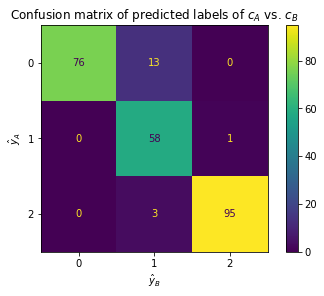

In [5]:
comparer.plot_confusion_matrix(X)

In [6]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker, algorithm='exact',
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['log_odds'])
with open('shap.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer),
                f, pickle.HIGHEST_PROTOCOL)

Using Exact algorithm
Using Exact algorithm
Using Exact algorithm


Exact explainer: 247it [01:55,  2.07it/s]                         
Exact explainer: 247it [01:47,  2.08it/s]                         
Exact explainer: 247it [07:35,  1.90s/it]                         

CPU times: user 12min 31s, sys: 2min 17s, total: 14min 49s
Wall time: 11min 18s


As we can see, no instances had infinite log-space predictions and no instances had infinite SHAP values:

In [7]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((246, 11), (0,), (0,))

# Traditional SHAP Explanations

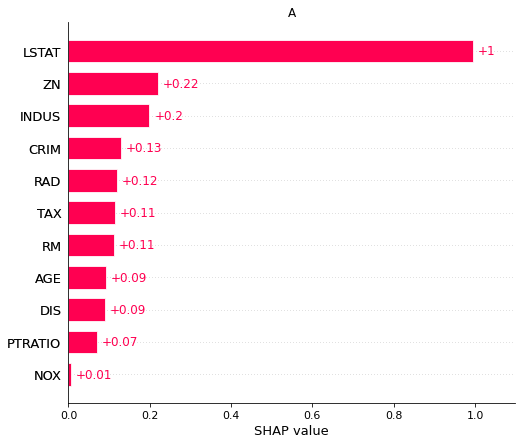

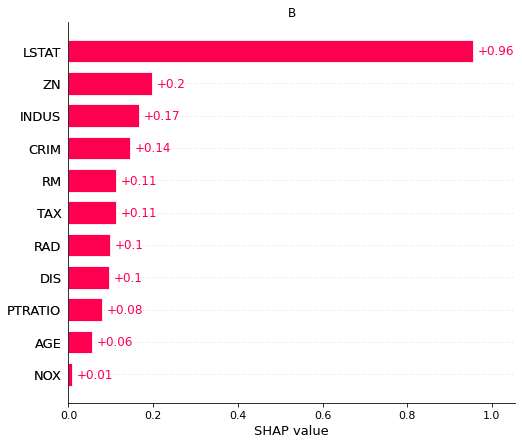

In [8]:
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.A)
plot_feature_importance_bar(feature_importances, 'A')
feature_order, feature_importances = calc_feature_order(explanations.indiv.log_odds.B)
plot_feature_importance_bar(feature_importances, 'B')

In [9]:
feature_order, _ = calc_feature_order(explanations.indiv.log_odds)
feature_order = feature_order[:-1]

In [10]:
node, Z = make_clustering(comparer, explanations.indiv.log_odds, categorical_features=categorical_features)

root
(2, 2)    95
(0, 0)    76
(1, 1)    58
(0, 1)    13
(2, 1)     3
(1, 2)     1
dtype: int64


In [11]:
feature_it = iter(feature_order)

In [12]:
def plot_next_feature():
    feature = next(feature_it)
    for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
        node.plot_feature(feature, classes=list(classes), alpha=0.5)

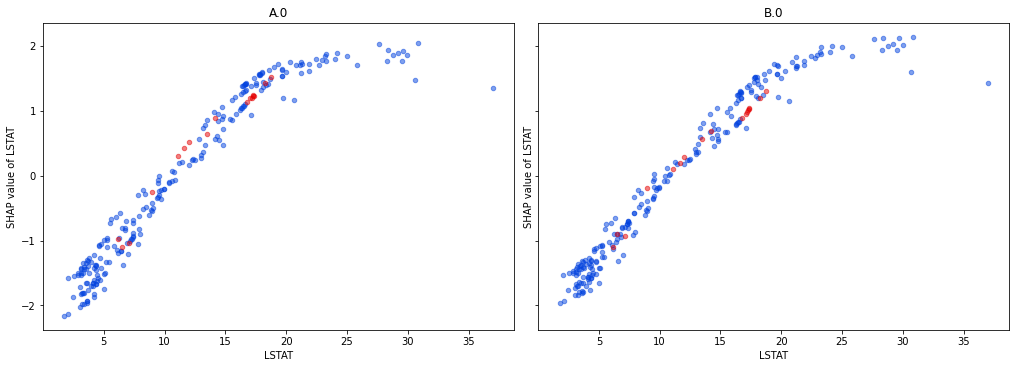

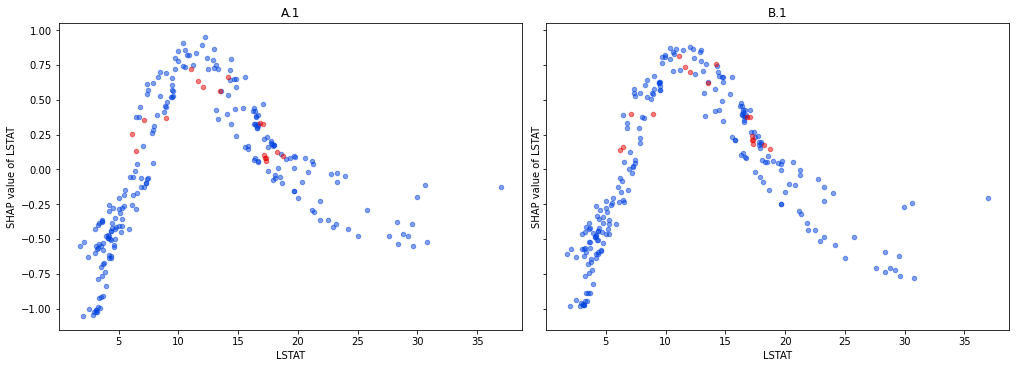

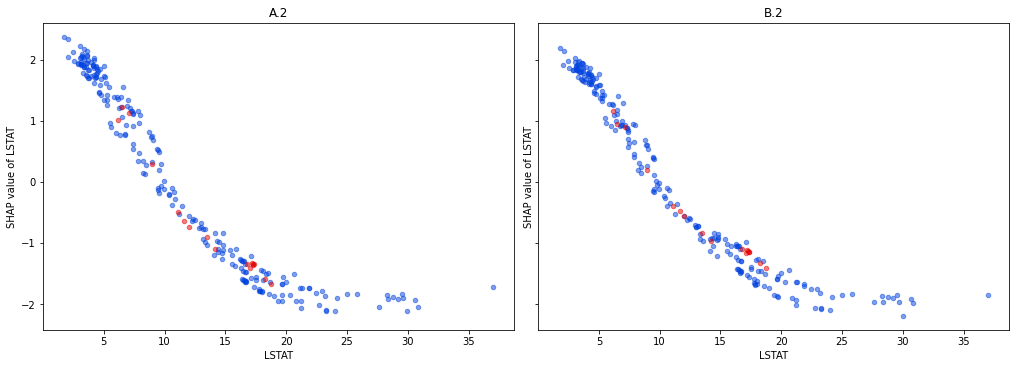

In [13]:
plot_next_feature()

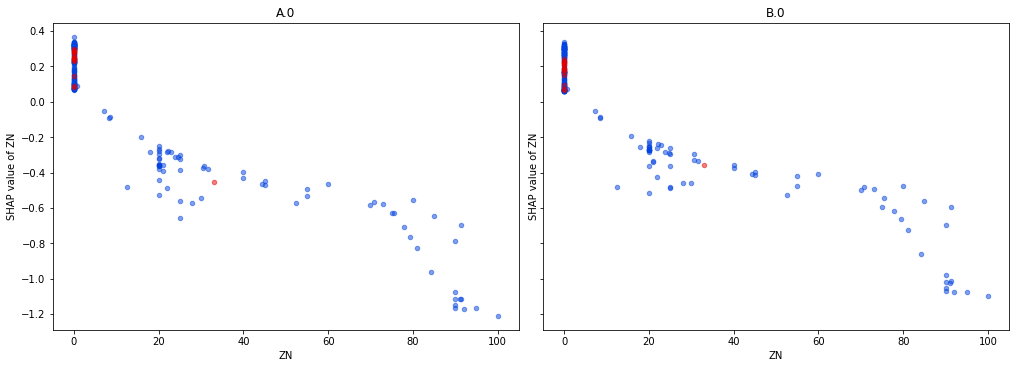

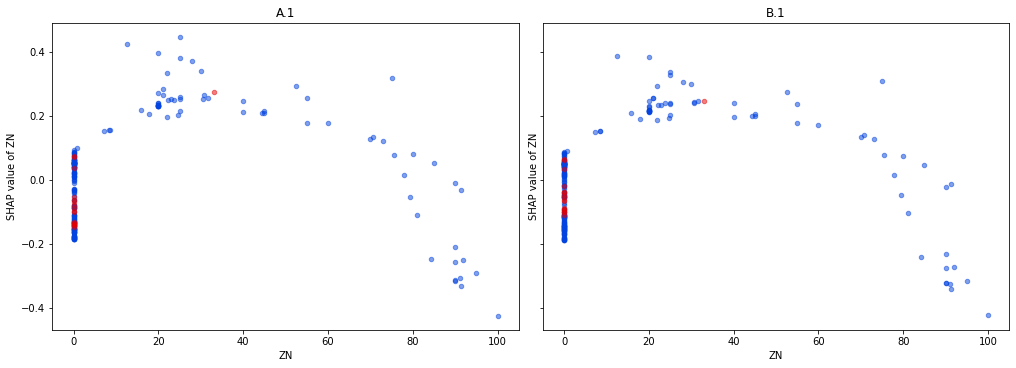

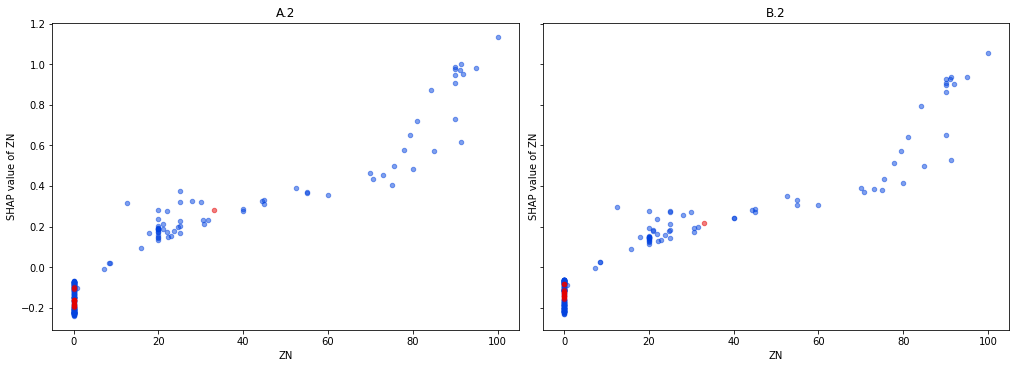

In [14]:
plot_next_feature()

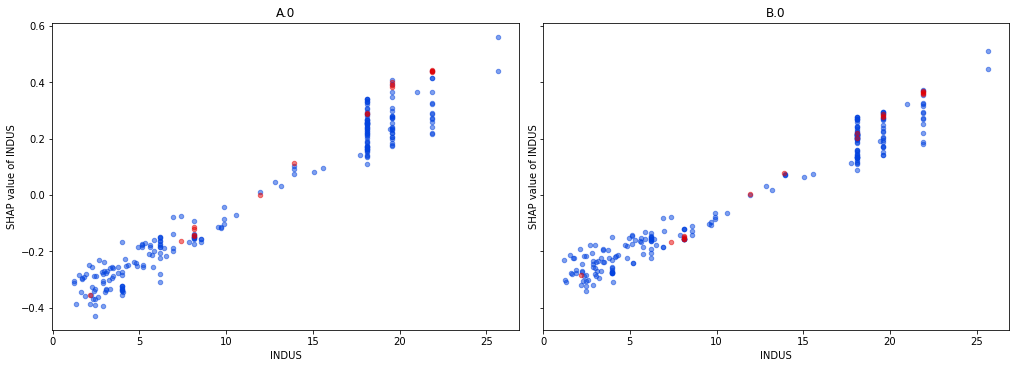

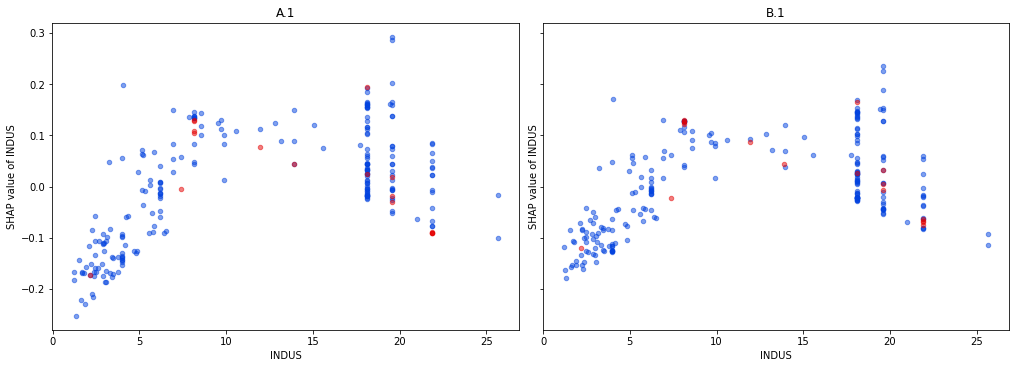

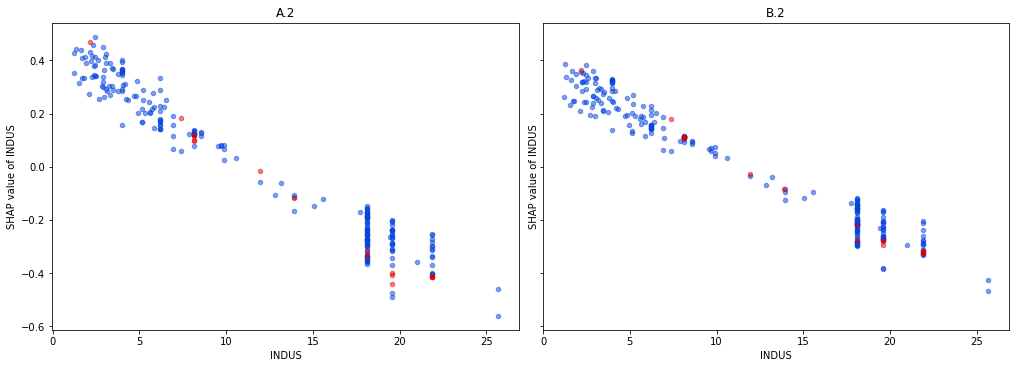

In [15]:
plot_next_feature()

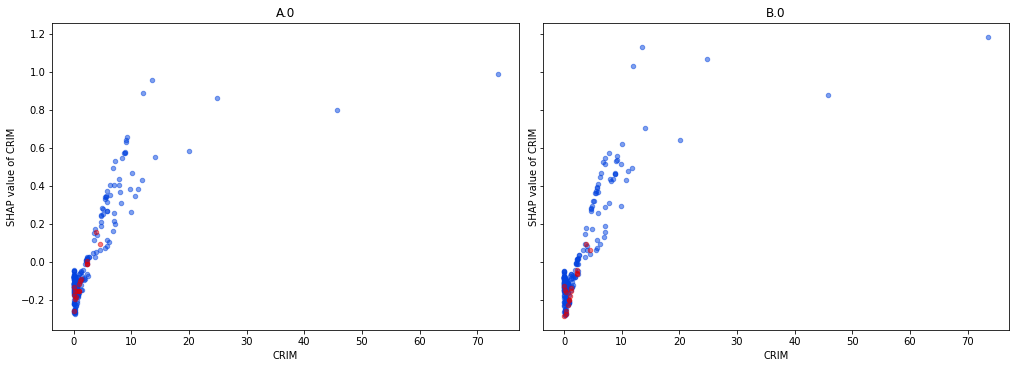

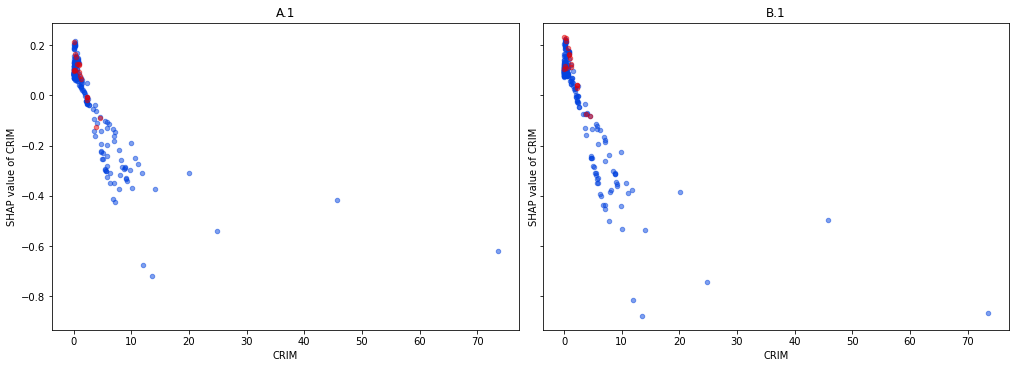

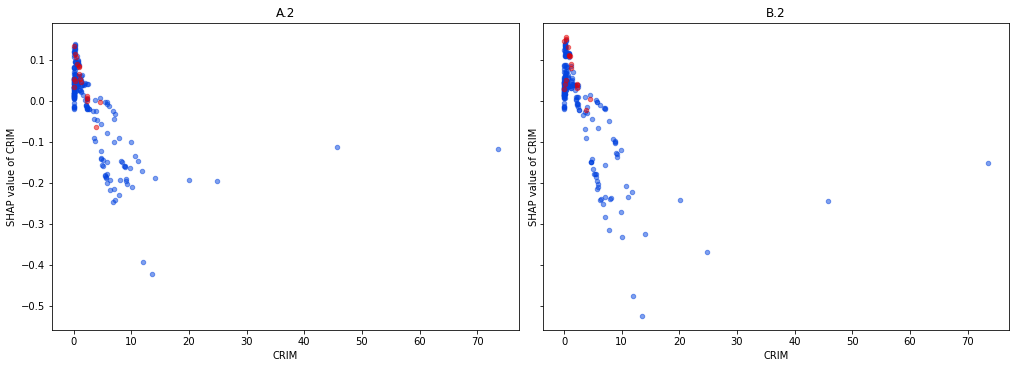

In [16]:
plot_next_feature()

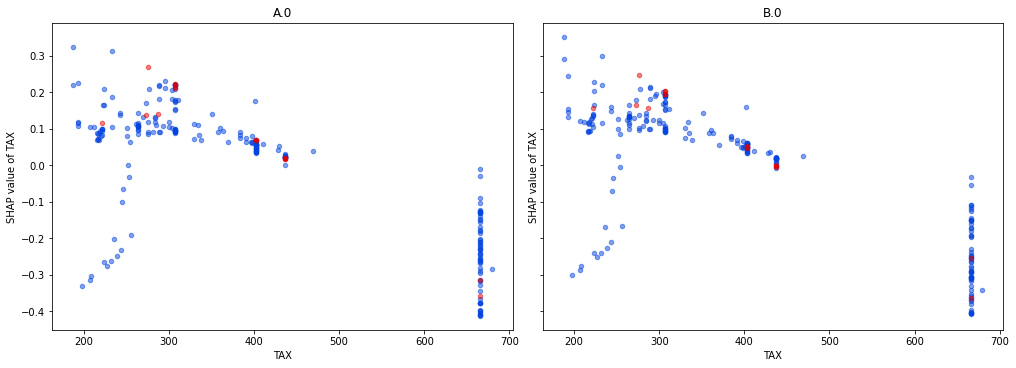

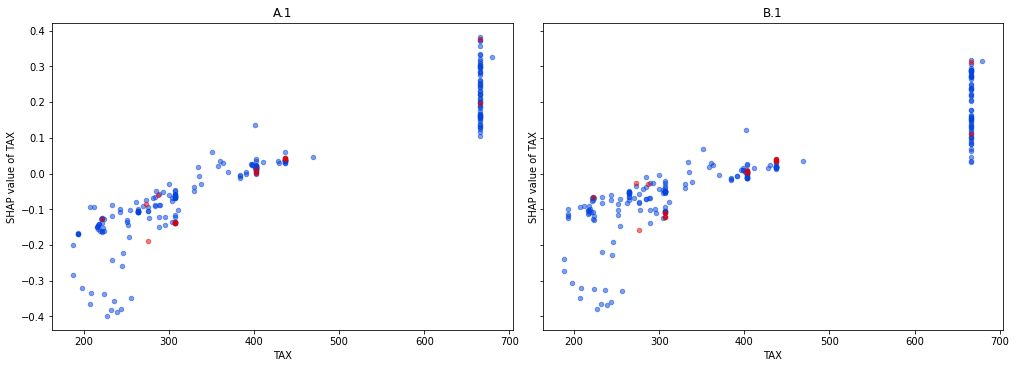

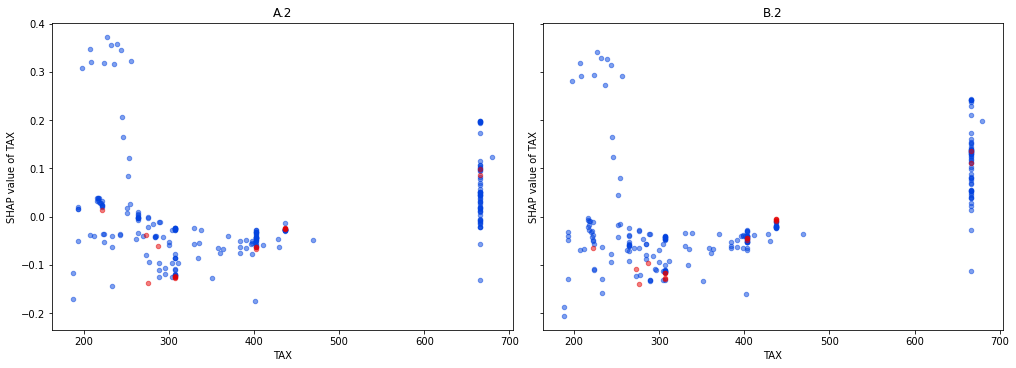

In [17]:
plot_next_feature()

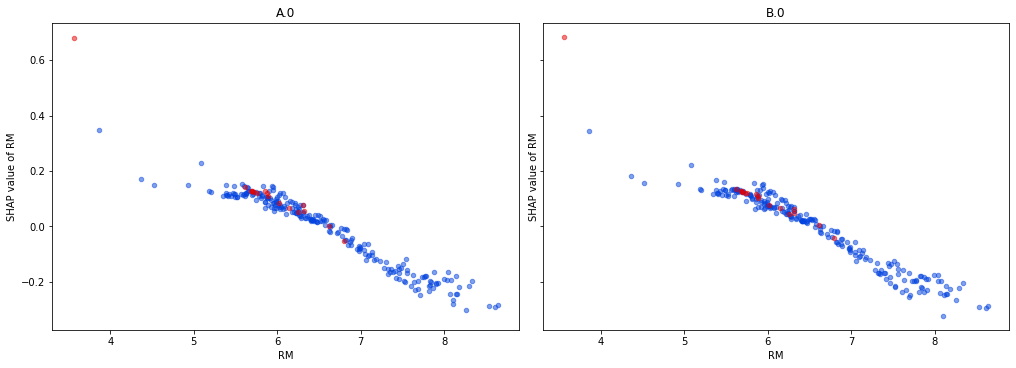

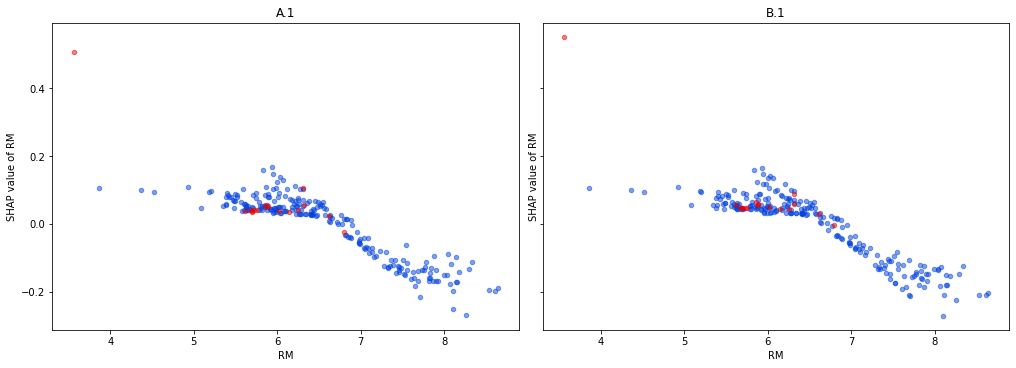

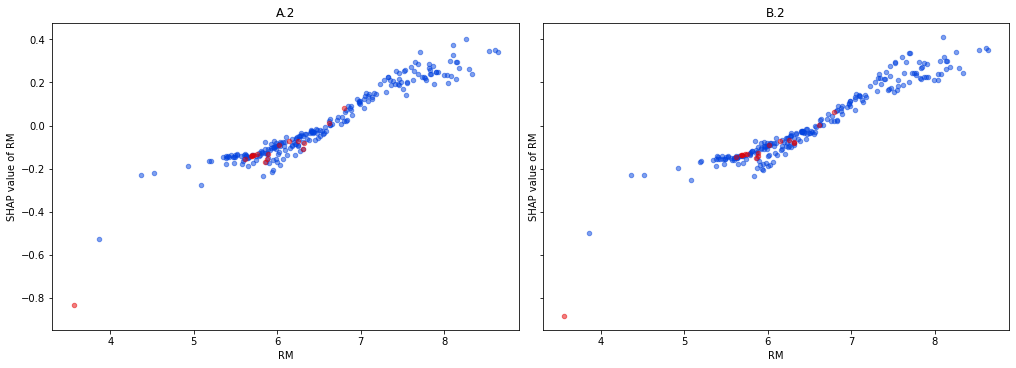

In [18]:
plot_next_feature()

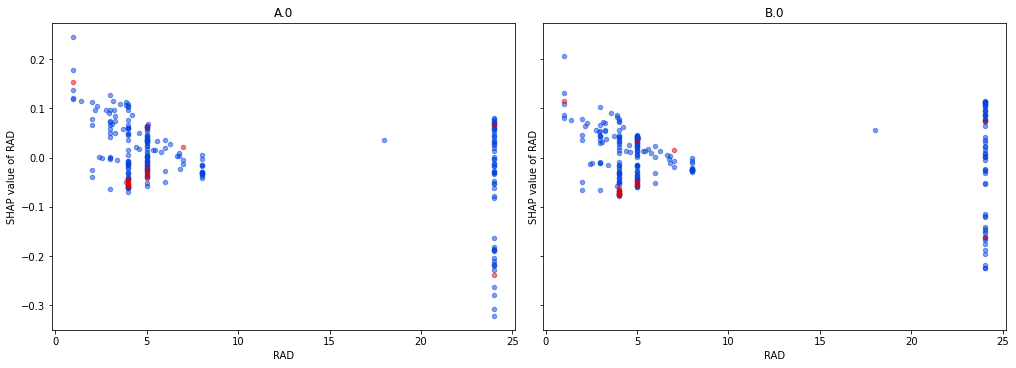

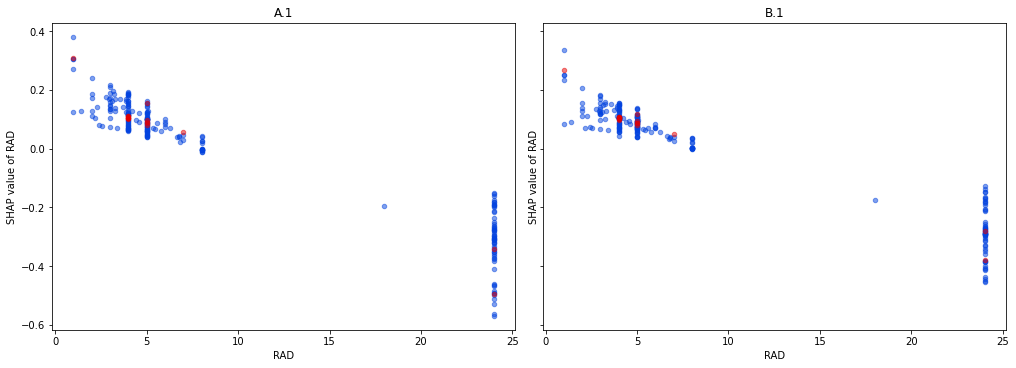

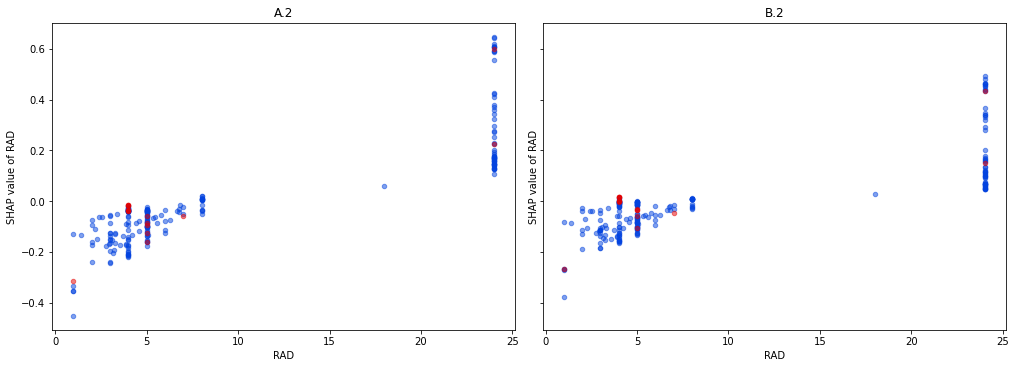

In [19]:
plot_next_feature()

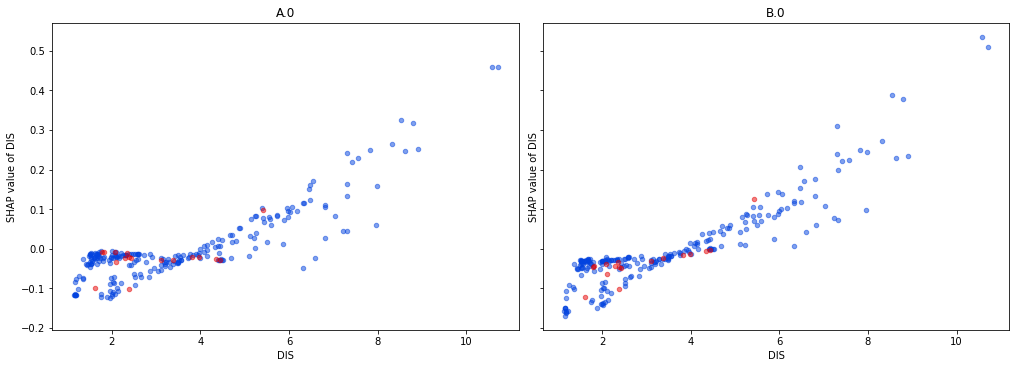

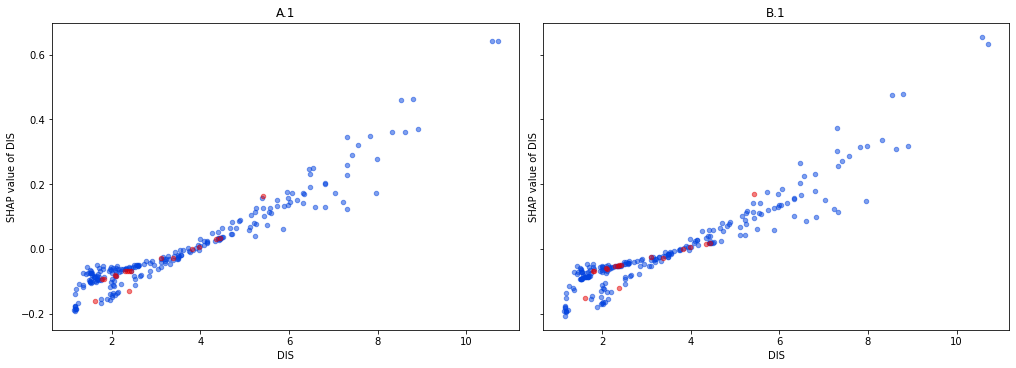

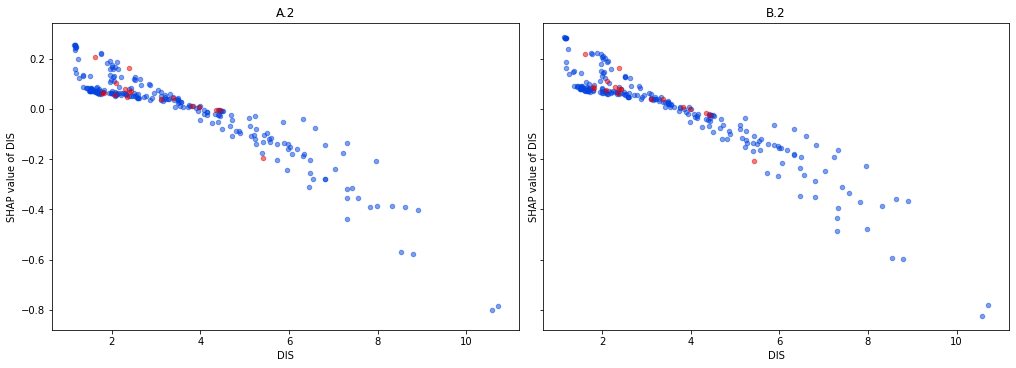

In [20]:
plot_next_feature()

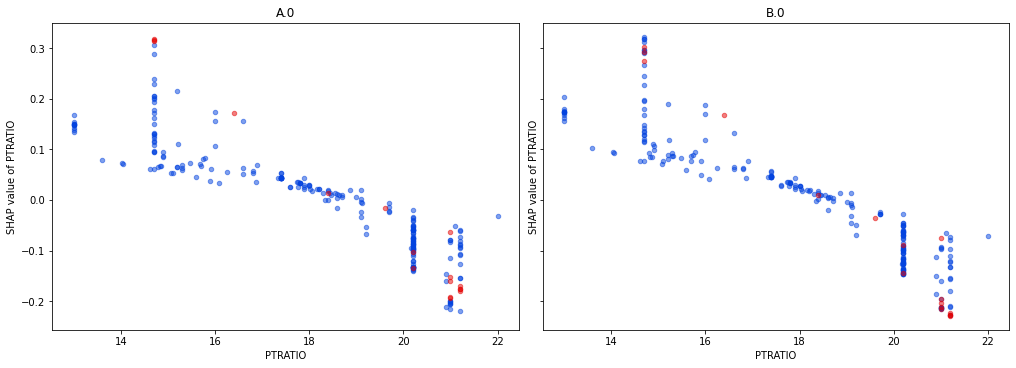

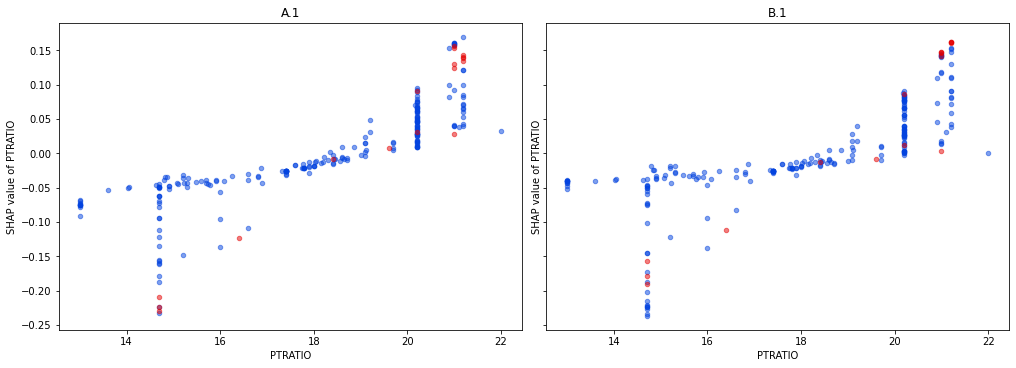

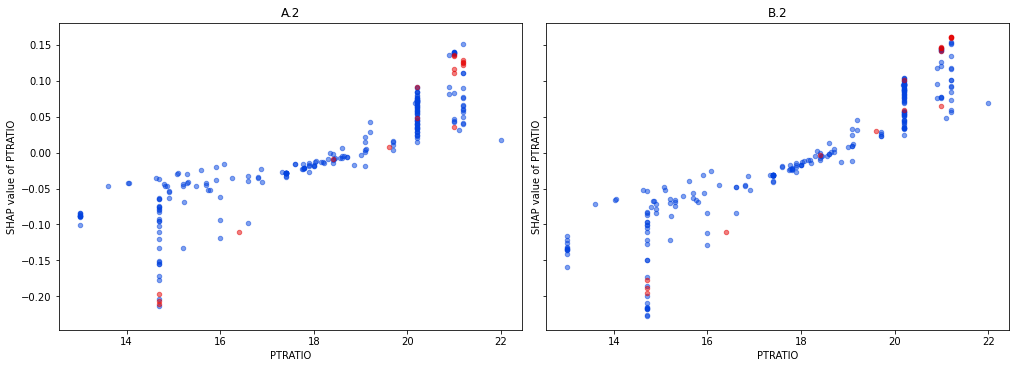

In [21]:
plot_next_feature()

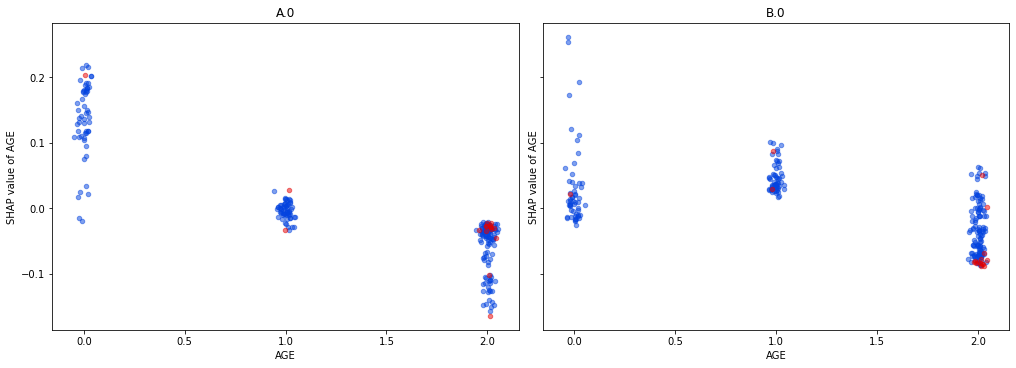

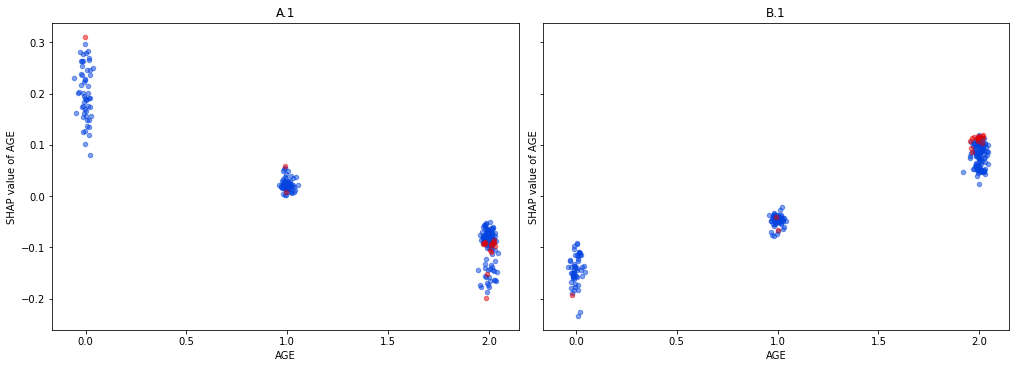

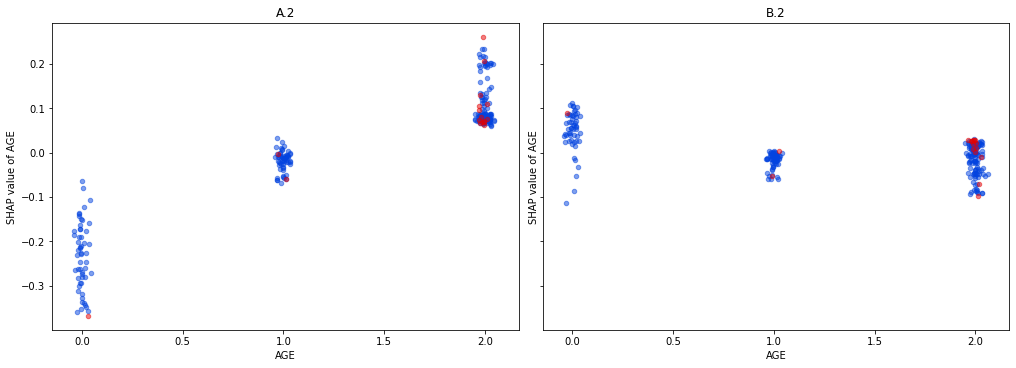

In [22]:
plot_next_feature()

# Difference Classifier SHAP Explanations

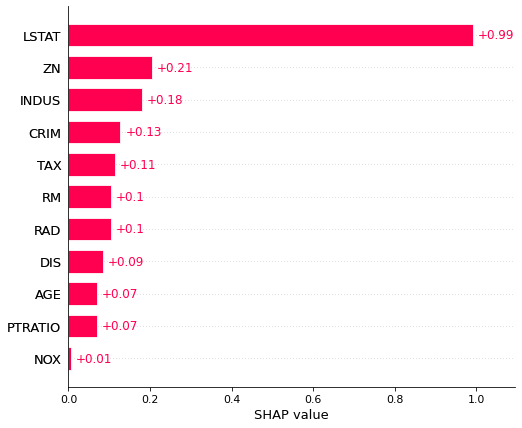

In [4]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.log_odds)
plot_feature_importance_bar(feature_importances)

In [5]:
feature_order = feature_order[:-1]
global_feature_order = feature_order

The equality classes (0,0) and (2,2) have the highest mean absolute SHAP value, which means that the influences to and from these classes are highest. 

(0,2) and (2,0) have the least importances.

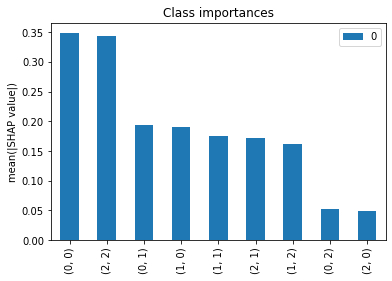

In [6]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.log_odds)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [7]:
class_order = np.sort(class_order[:-2])

## Clustering of Class $(0,1)$ SHAP Values

In [27]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds, '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'],
                          categorical_features=categorical_features)

root
(2, 2)    95
(0, 0)    76
(1, 1)    58
(0, 1)    13
(2, 1)     3
(1, 2)     1
dtype: int64


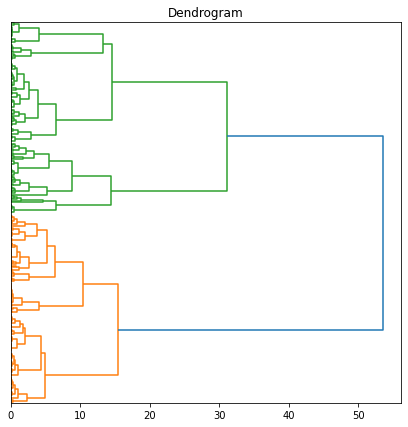

In [9]:
plot_dendrogram(Z)

### Root Node

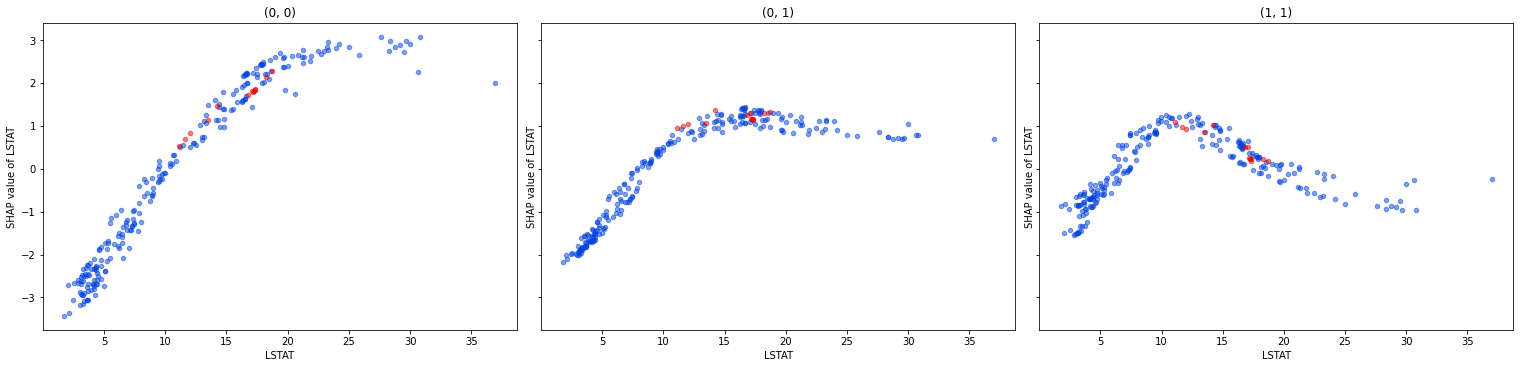

In [10]:
node.plot_feature('LSTAT', alpha=0.5)

In [11]:
node.describe_feature('LSTAT')

global   local-all  local-diff
count  246.000000  246.000000   13.000000
mean    11.736981   11.736981   15.570054
std      7.372550    7.372550    2.686952
min      1.763949    1.763949   11.100000
25%      5.008267    5.008267   13.510000
50%      9.950000    9.950000   17.066695
75%     17.091674   17.091674   17.310000
max     36.980000   36.980000   18.720000

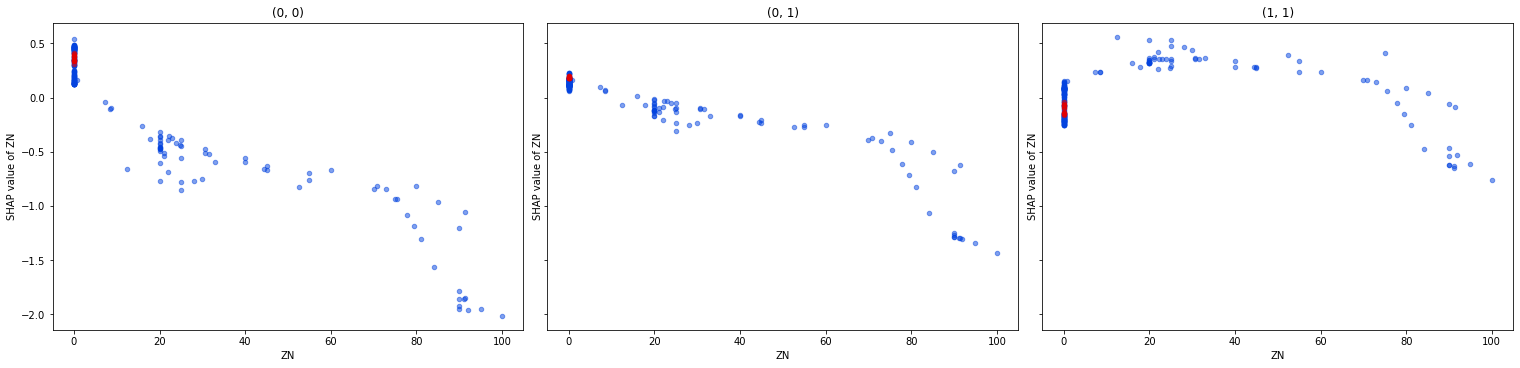

In [12]:
node.plot_feature('ZN', alpha=0.5)

In [13]:
node.describe_feature('ZN')

global   local-all  local-diff
count  246.000000  246.000000        13.0
mean    12.841063   12.841063         0.0
std     25.552540   25.552540         0.0
min      0.000000    0.000000         0.0
25%      0.000000    0.000000         0.0
50%      0.000000    0.000000         0.0
75%     20.000000   20.000000         0.0
max    100.000000  100.000000         0.0

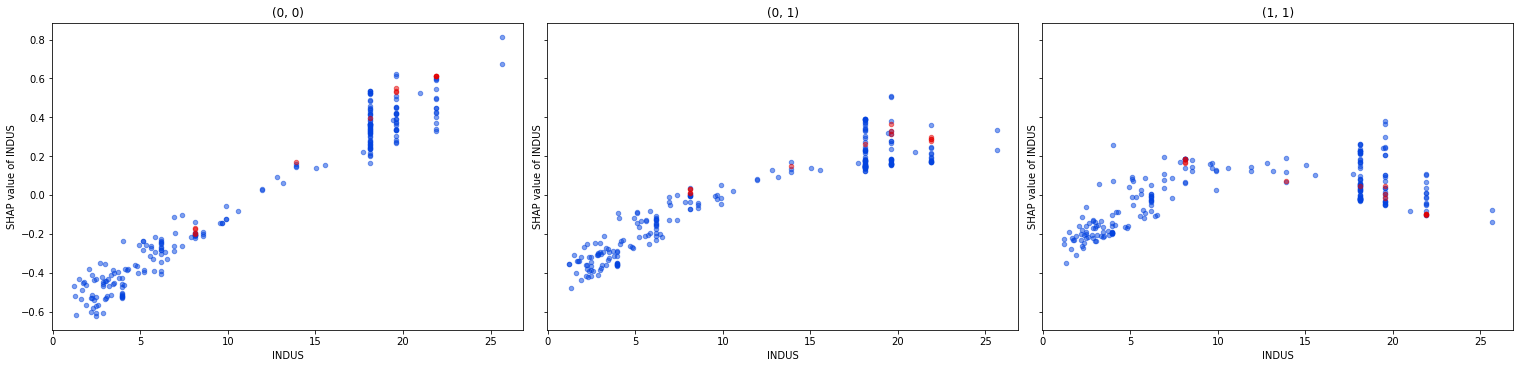

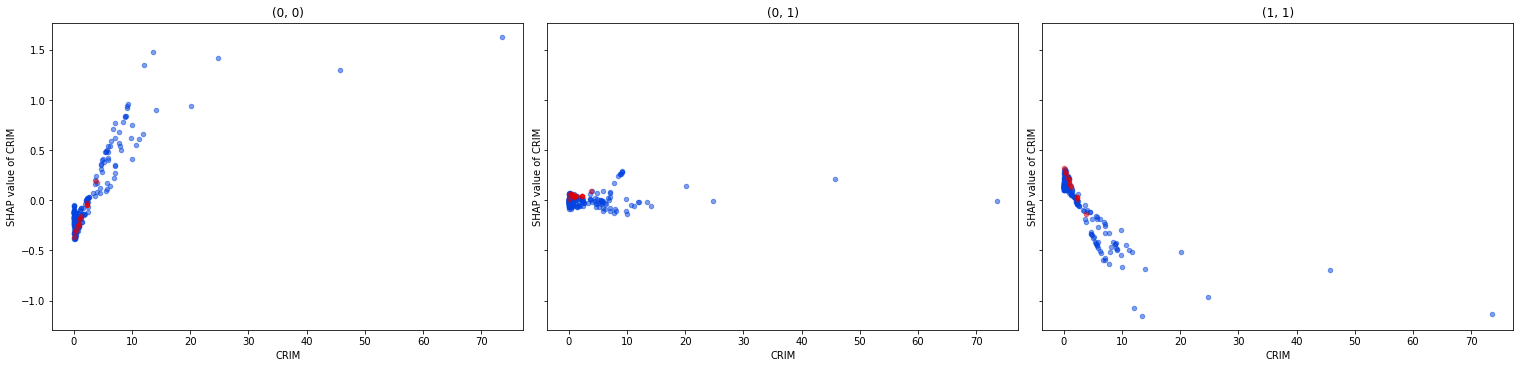

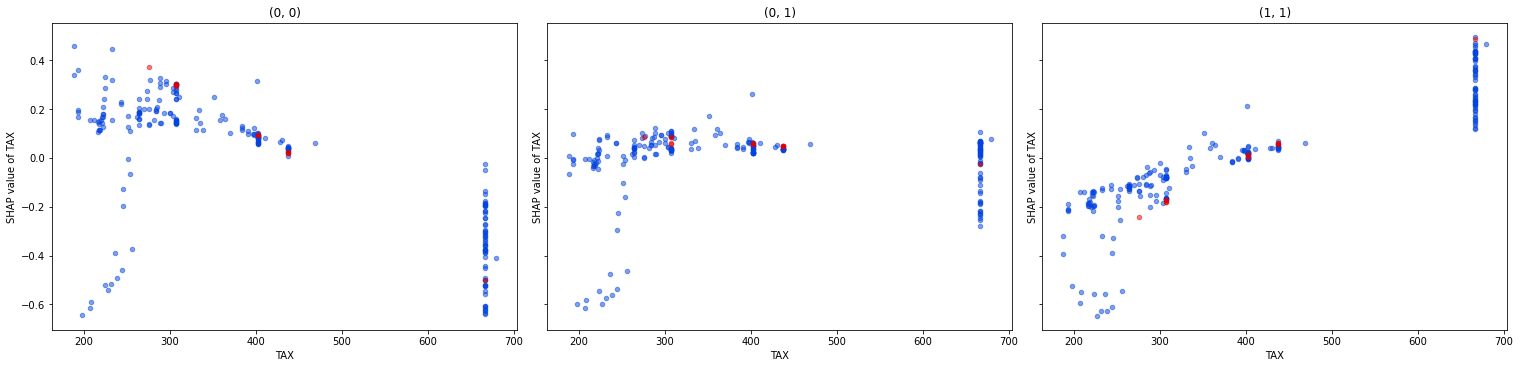

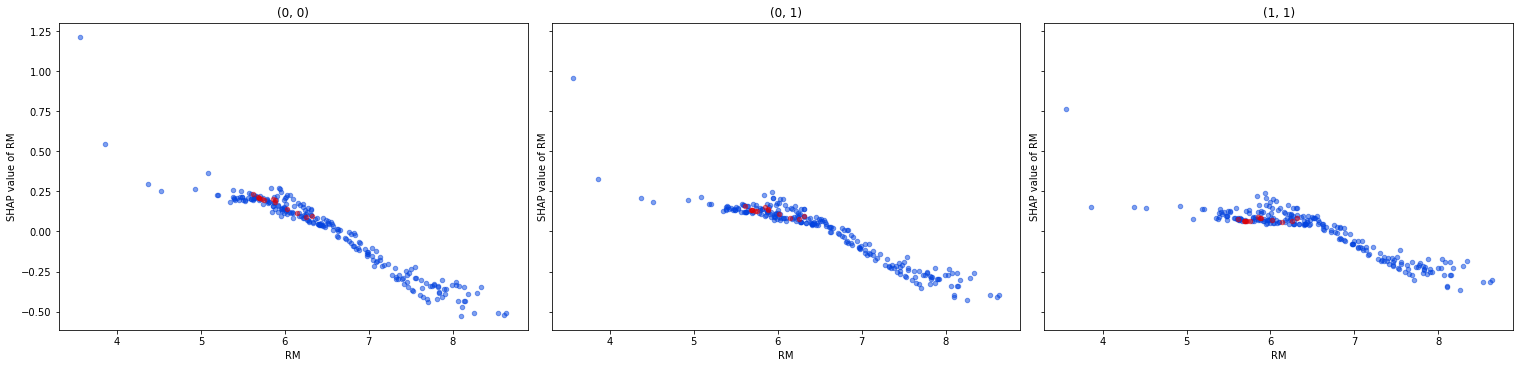

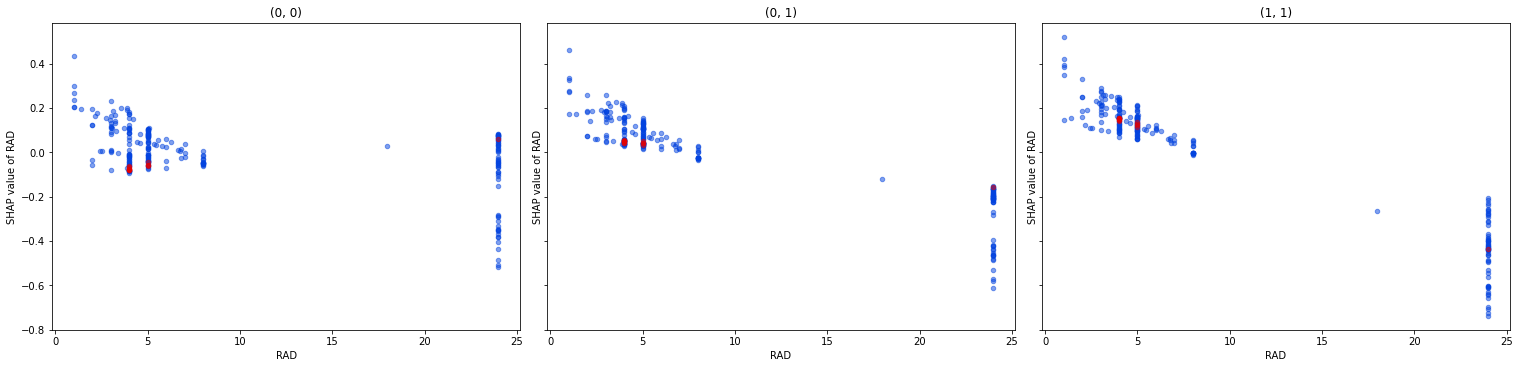

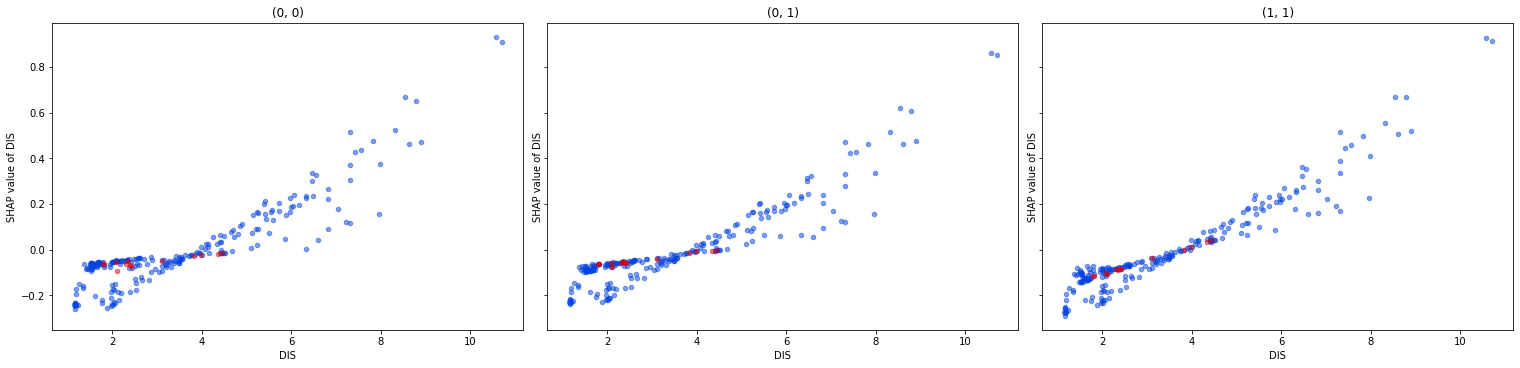

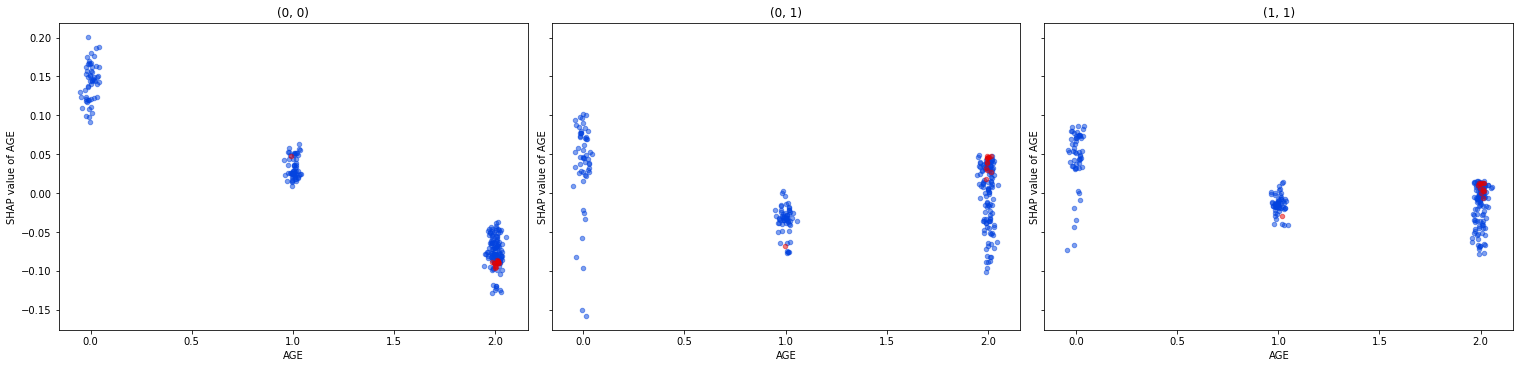

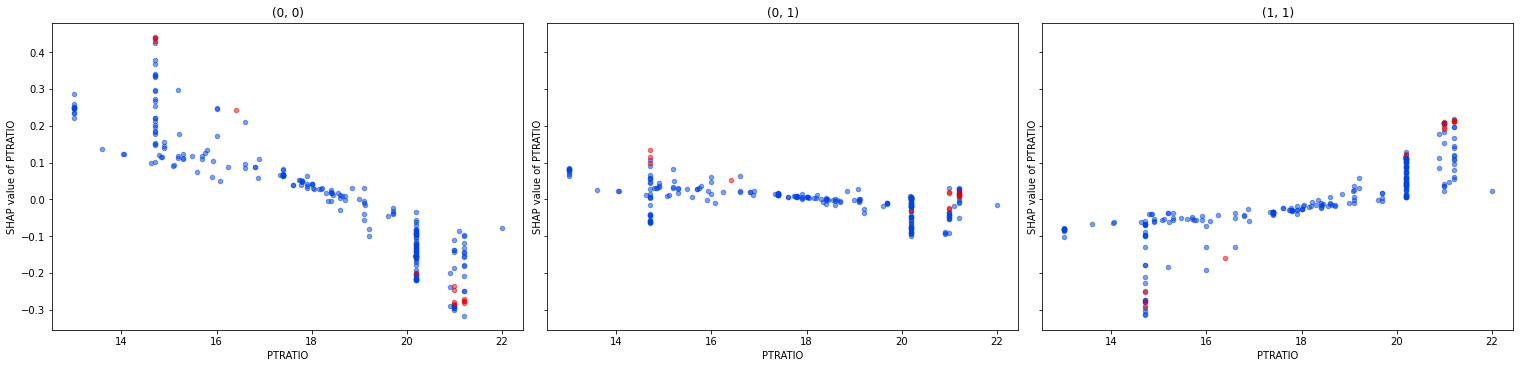

In [14]:
for feature in global_feature_order[2:]:
    node.plot_feature(feature, alpha=0.5)

In [28]:
node.describe_feature('CRIM')

global   local-all  local-diff
count  246.000000  246.000000   13.000000
mean     2.720010    2.720010    1.316509
std      6.388147    6.388147    1.073462
min      0.009060    0.009060    0.045600
25%      0.099321    0.099321    0.626837
50%      0.540032    0.540032    0.976170
75%      3.181873    3.181873    2.242360
max     73.534100   73.534100    3.836840

In [33]:
node.test(CRIM=7)

before  after
(0, 0)     NaN   13.0
(0, 1)    13.0    NaN

### Node L

In [15]:
node = node.get_left()

L
(0, 0)    76
(1, 1)    33
(0, 1)    13
dtype: int64


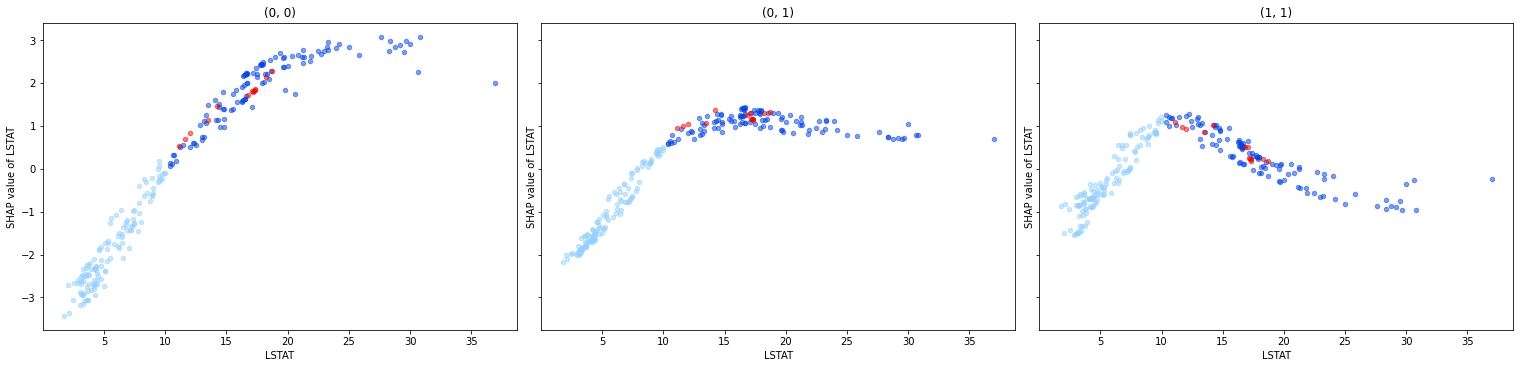

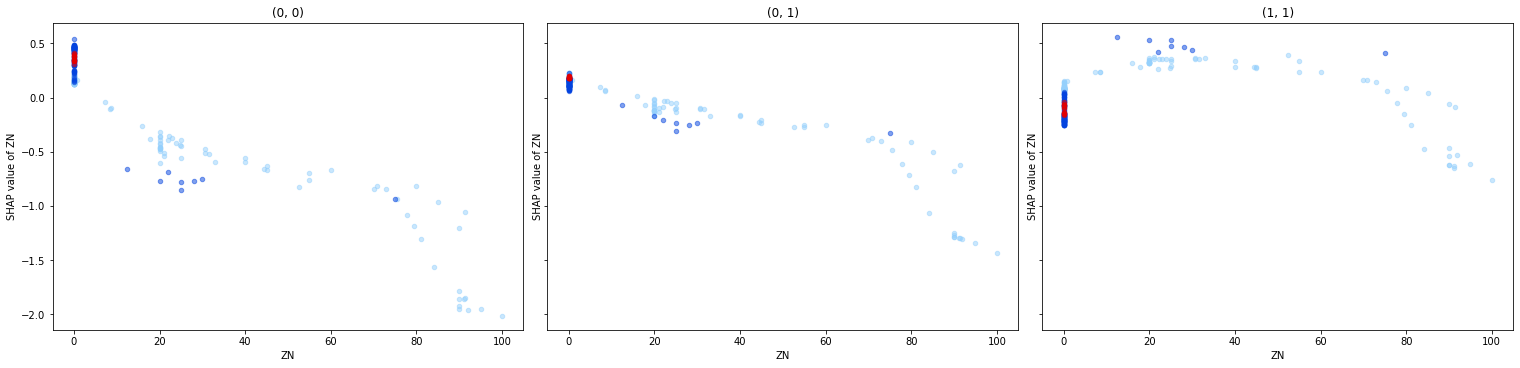

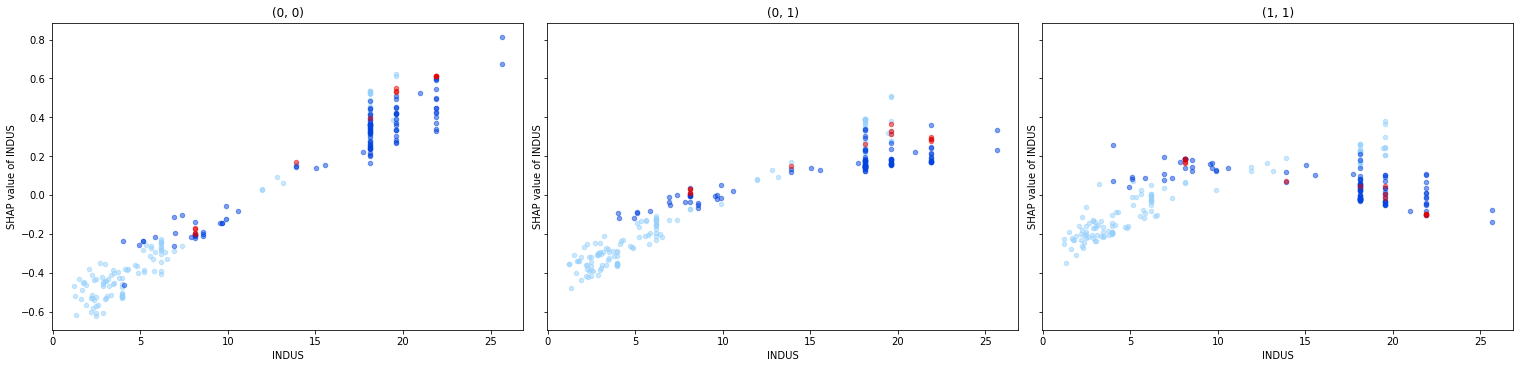

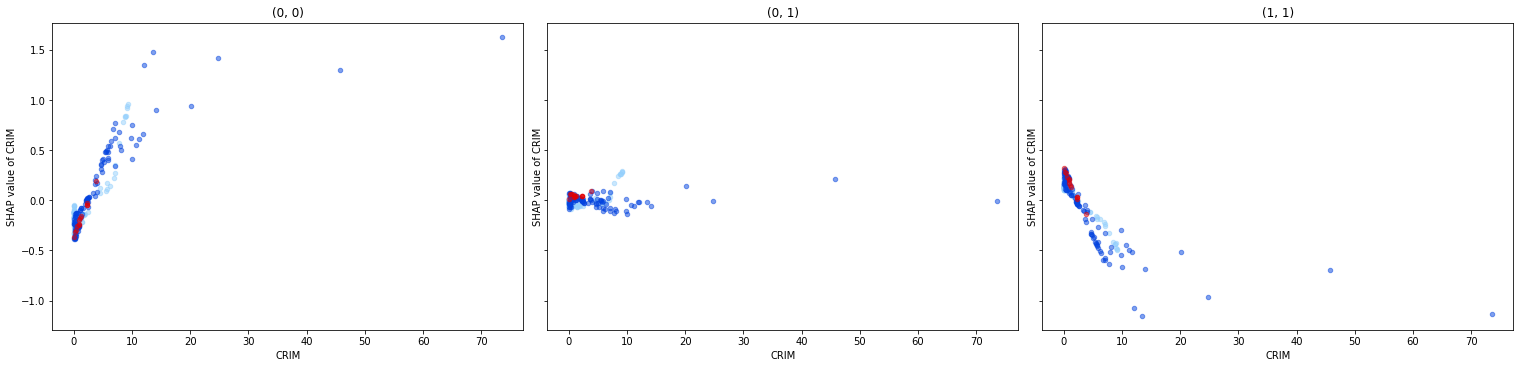

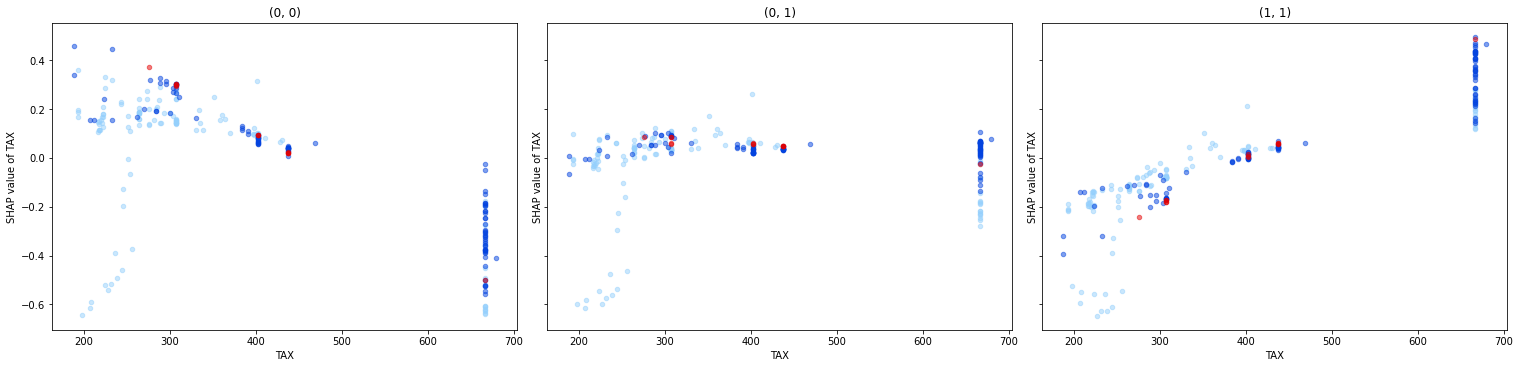

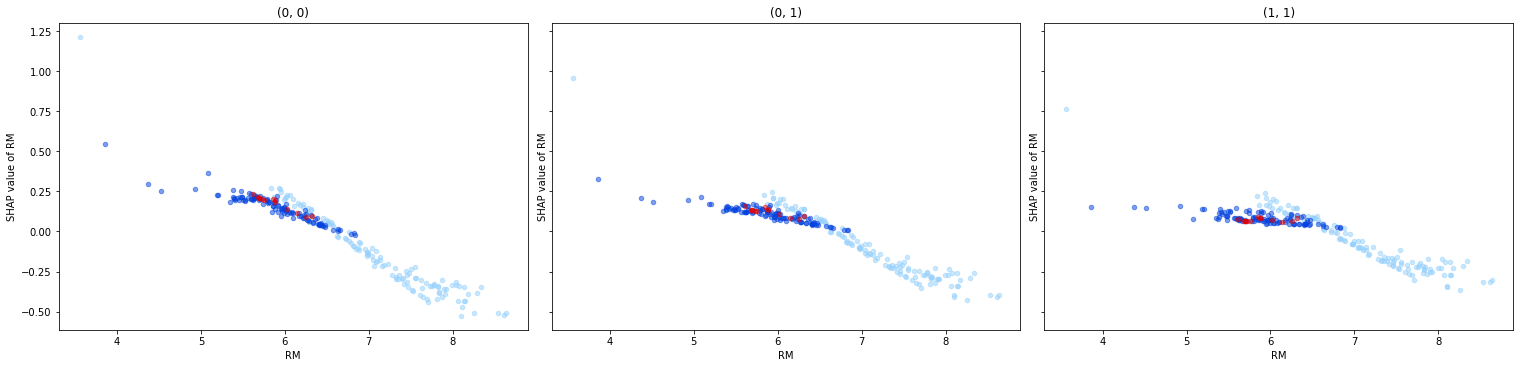

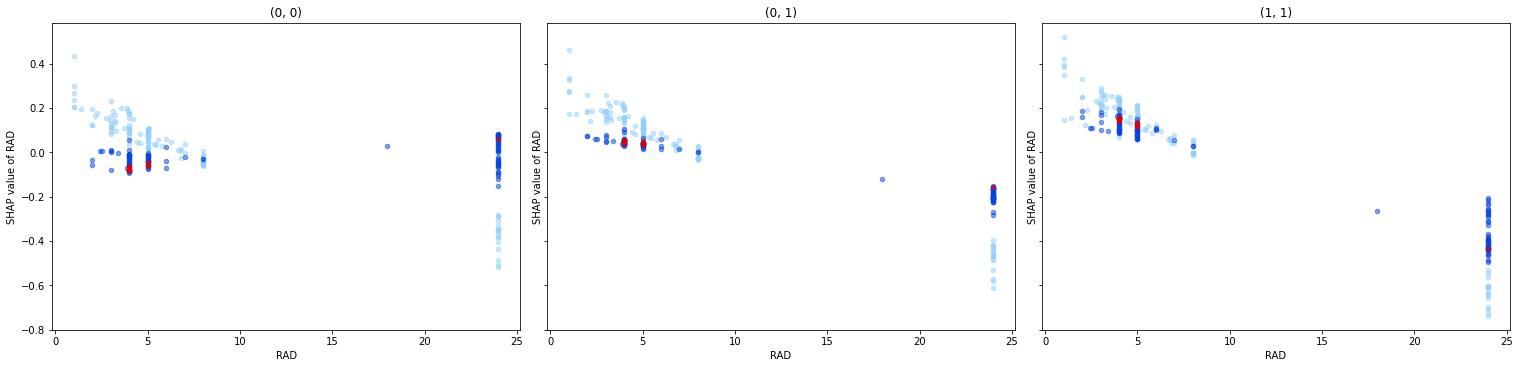

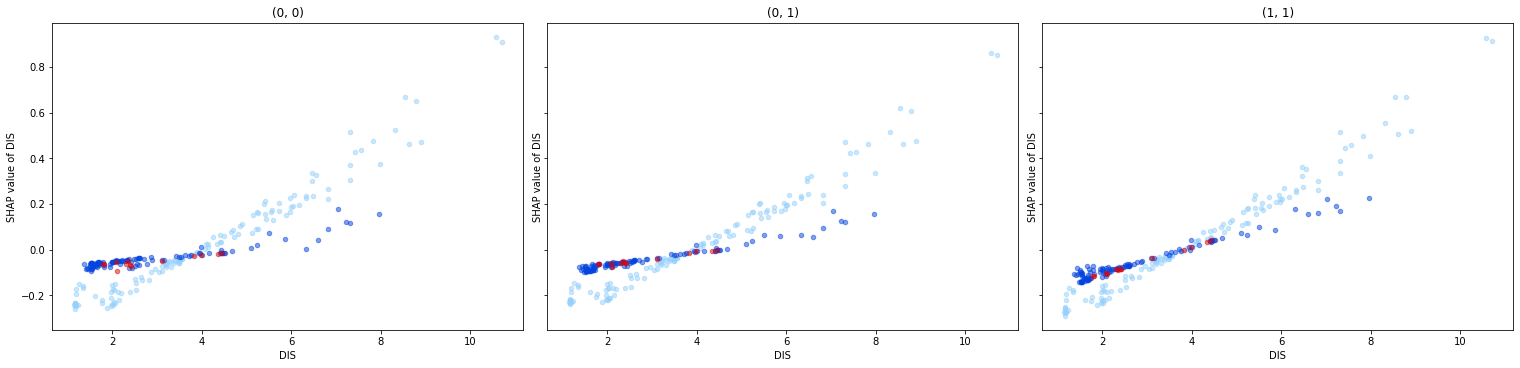

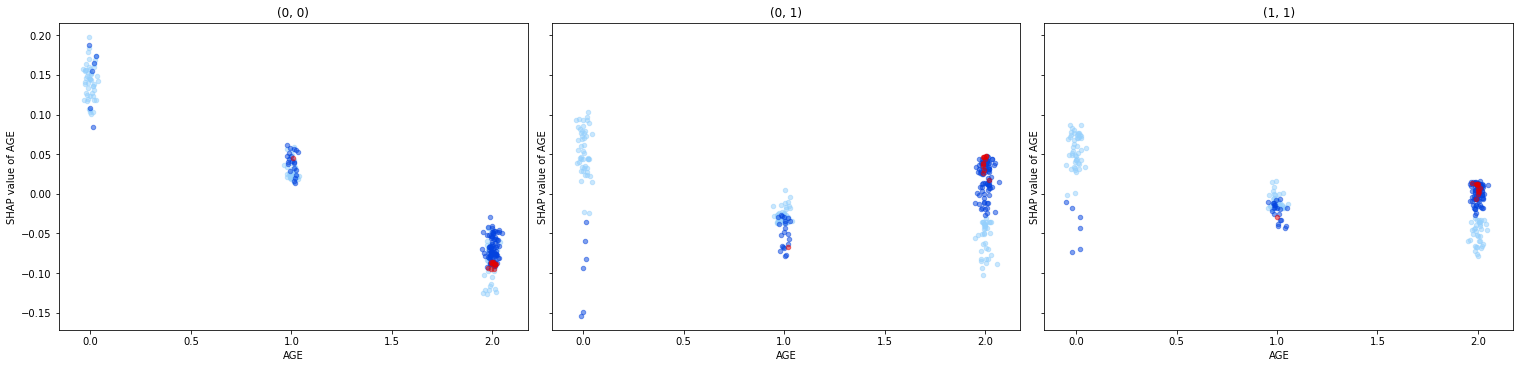

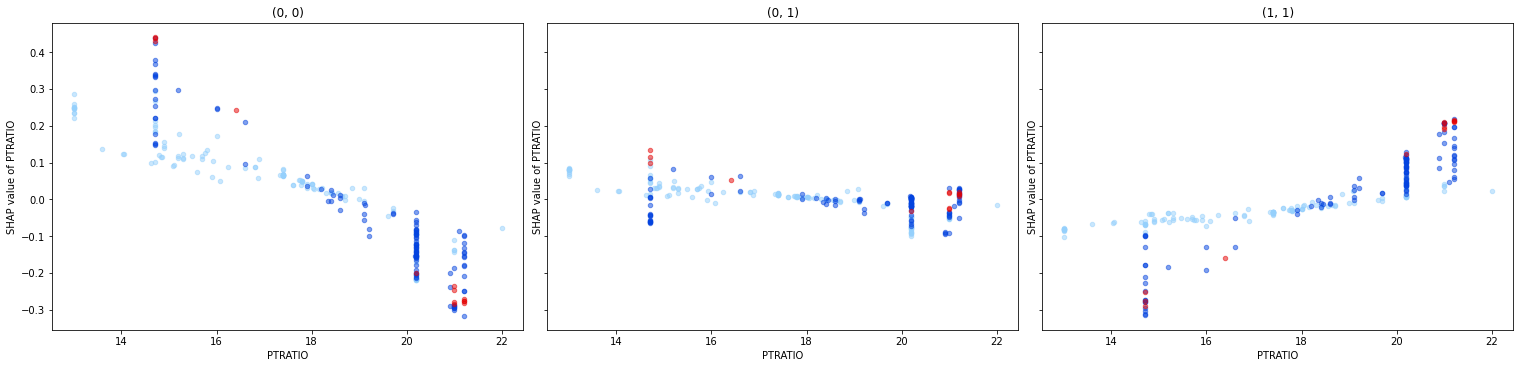

In [17]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [16]:
node.describe_feature('LSTAT')

global   local-all  local-diff
count  246.000000  122.000000   13.000000
mean    11.736981   18.011056   15.570054
std      7.372550    5.137193    2.686952
min      1.763949   10.360000   11.100000
25%      5.008267   14.502500   13.510000
50%      9.950000   17.125000   17.066695
75%     17.091674   19.936436   17.310000
max     36.980000   36.980000   18.720000

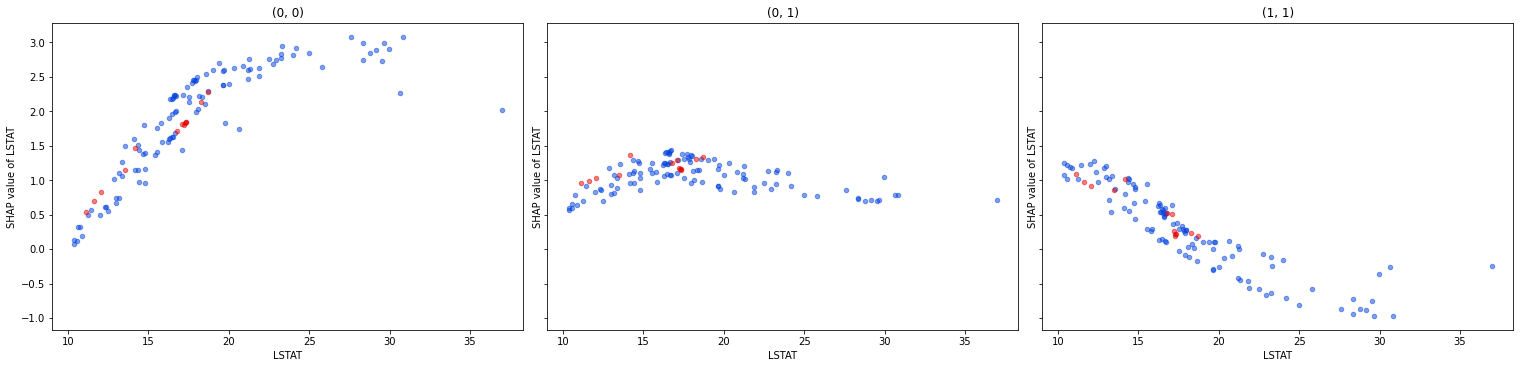

In [18]:
node.plot_feature('LSTAT', alpha=0.5)

In [19]:
node.test(LSTAT=10.2)

before  after
(0, 1)    13.0    NaN
(1, 1)     NaN   13.0

In [20]:
node.test(LSTAT=19.2)

before  after
(0, 0)     NaN   13.0
(0, 1)    13.0    NaN

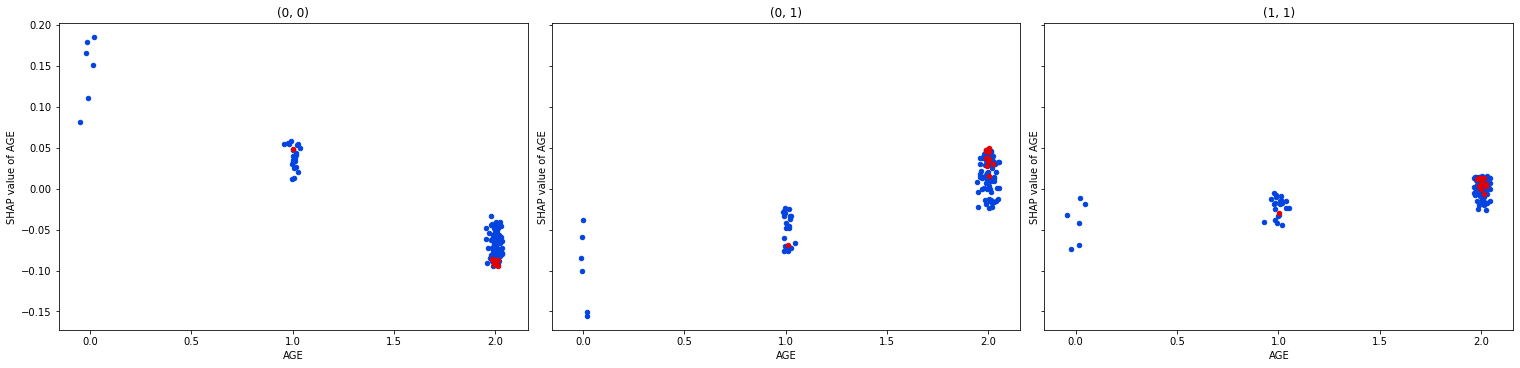

In [21]:
node.plot_feature('AGE')

In [22]:
node.test(AGE=0)

before  after
(0, 0)     NaN    8.0
(0, 1)    13.0    NaN
(1, 0)     NaN    5.0

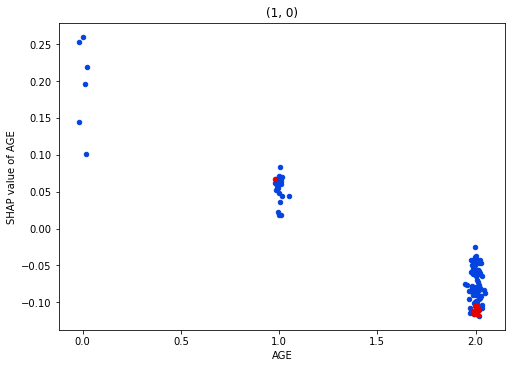

In [23]:
node.plot_feature('AGE', ['(1, 0)'])

In [24]:
node.test(ZN=6)

before  after
(0, 1)    13.0    NaN
(1, 1)     NaN   13.0

In [25]:
node.describe_feature('INDUS')

global   local-all  local-diff
count  246.000000  122.000000   13.000000
mean    11.718208   16.181280   16.219231
std      7.290396    5.426436    6.003980
min      1.210000    4.000000    8.140000
25%      4.243588   10.072500    8.140000
50%      9.900000   18.100000   19.580000
75%     18.100000   19.580000   21.890000
max     25.650000   25.650000   21.890000

In [26]:
node.test(INDUS=1)

before  after
(0, 1)    13.0      2
(1, 1)     NaN     11

## Clustering of Class $(1,2)$ SHAP Values

In [34]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds, '(1, 2)', ['(1, 1)', '(1, 2)', '(2, 2)'],
                          categorical_features=categorical_features)

root
(2, 2)    95
(0, 0)    76
(1, 1)    58
(0, 1)    13
(2, 1)     3
(1, 2)     1
dtype: int64


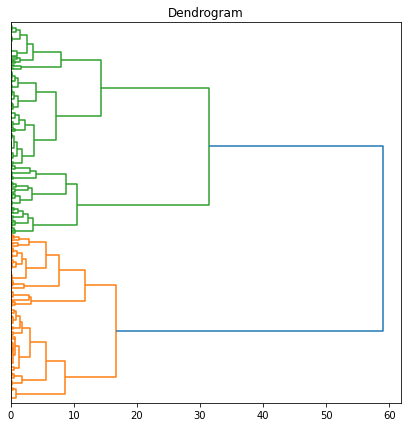

In [35]:
plot_dendrogram(Z)

### Root Node

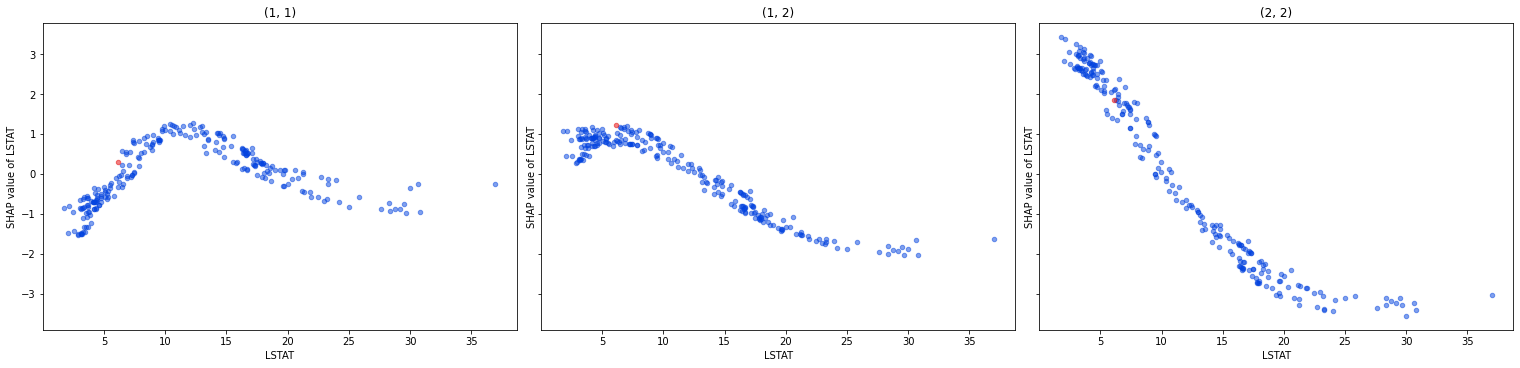

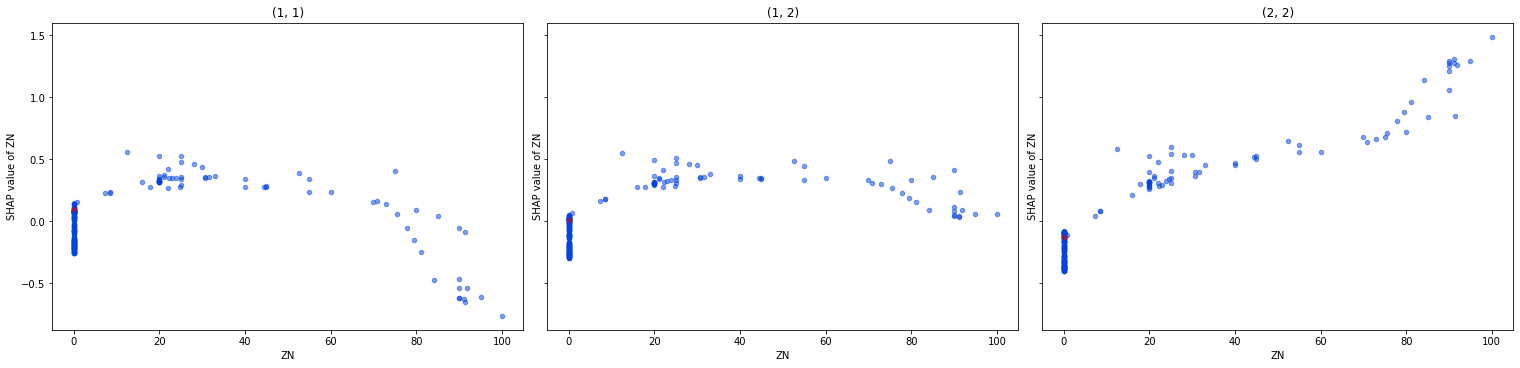

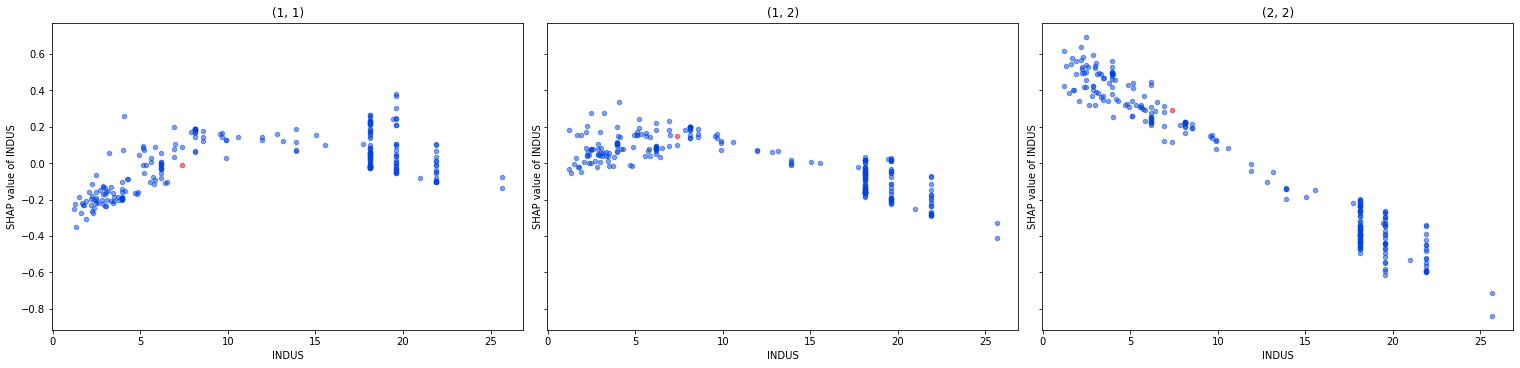

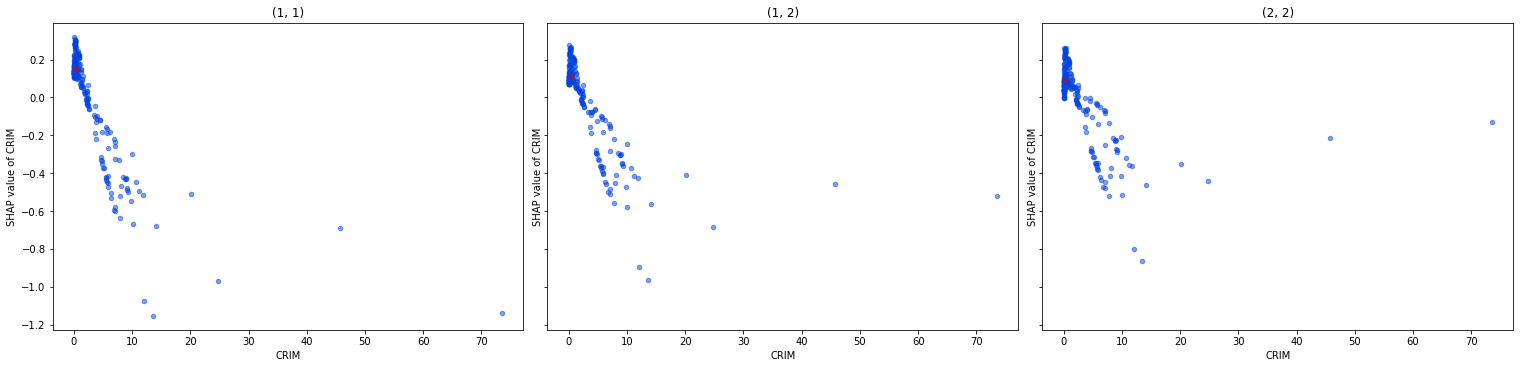

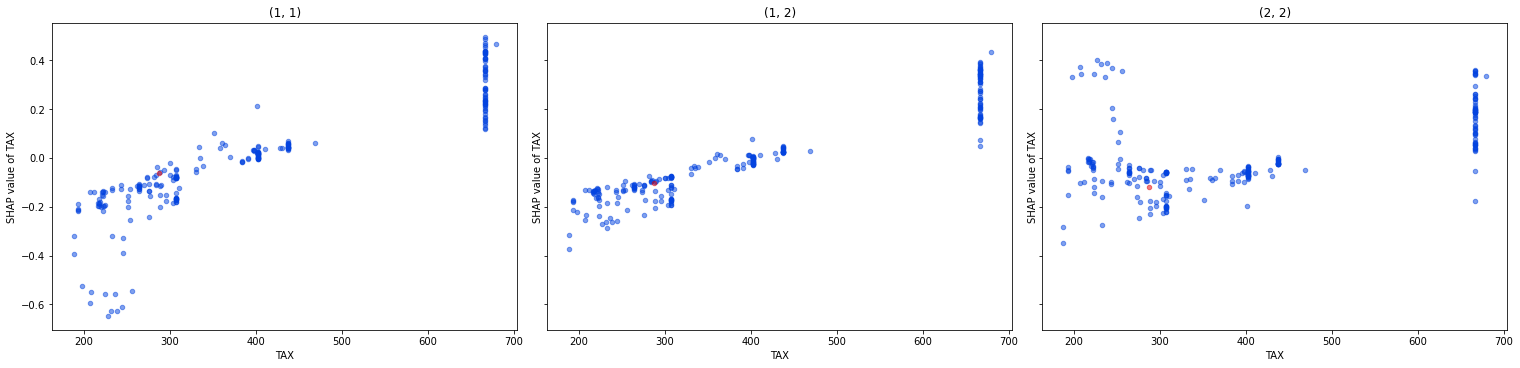

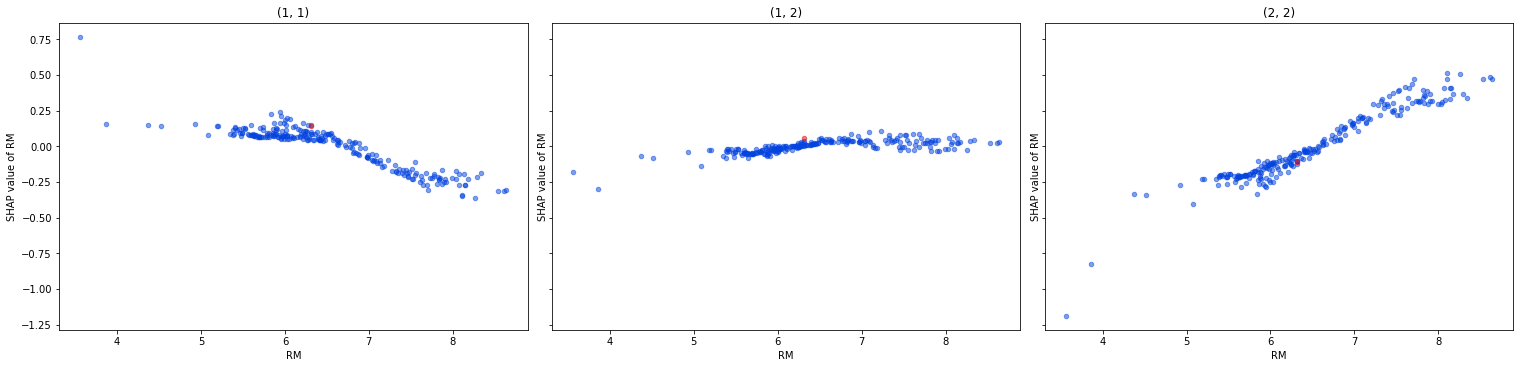

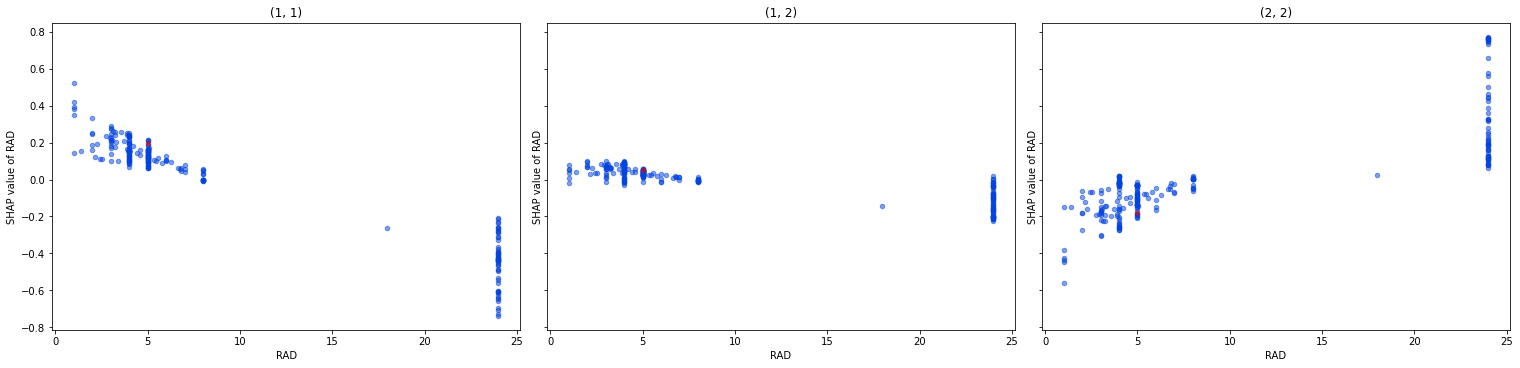

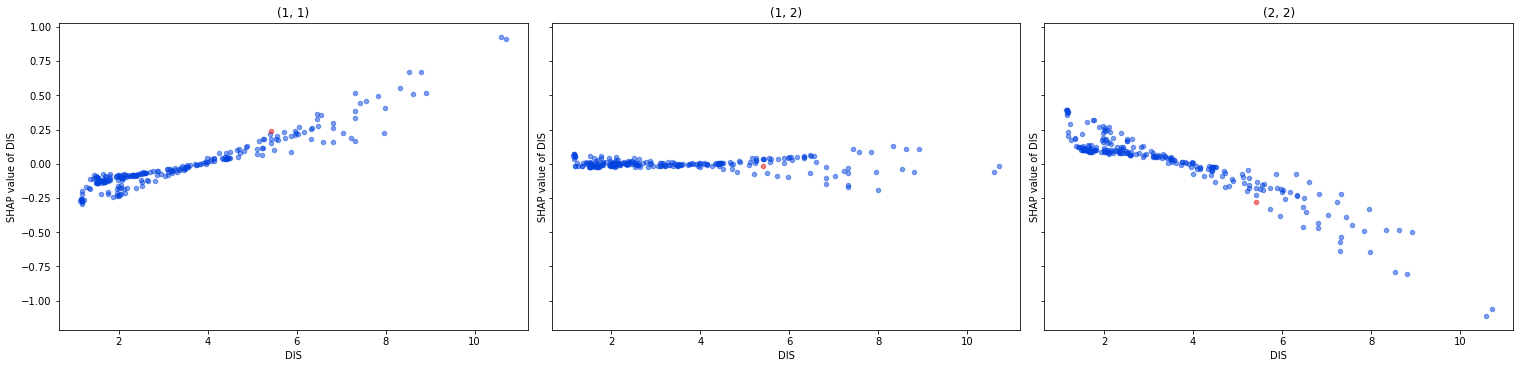

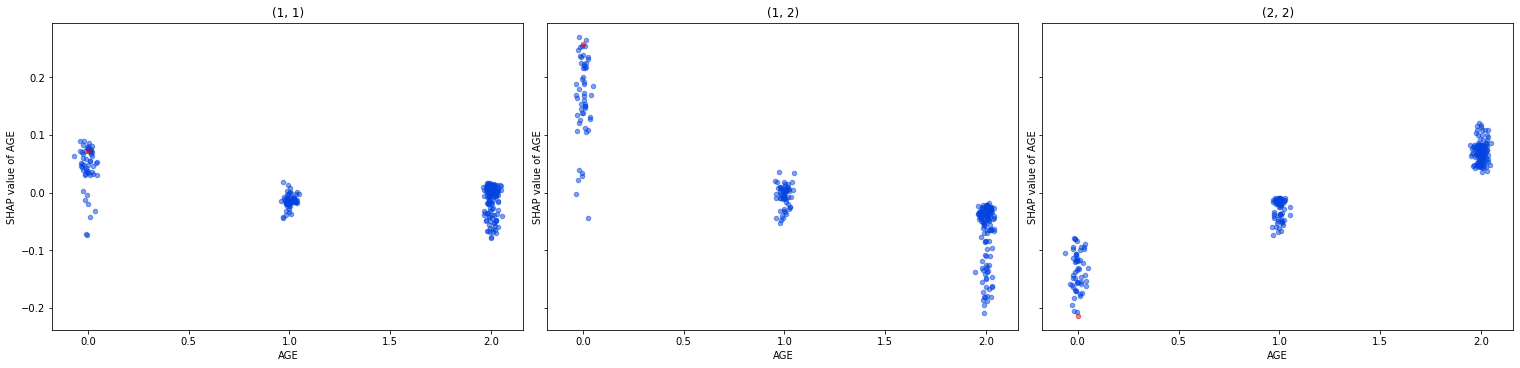

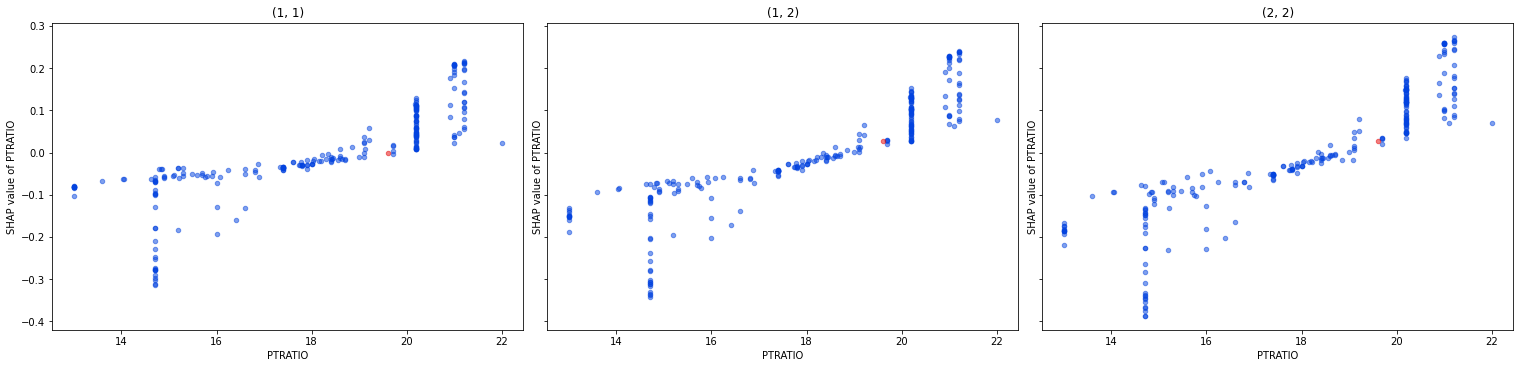

In [36]:
for feature in global_feature_order:
    node.plot_feature(feature, alpha=0.5)

### Node L

In [38]:
node = node.get_left()

L
(2, 2)    95
(1, 1)    11
(2, 1)     2
(1, 2)     1
dtype: int64


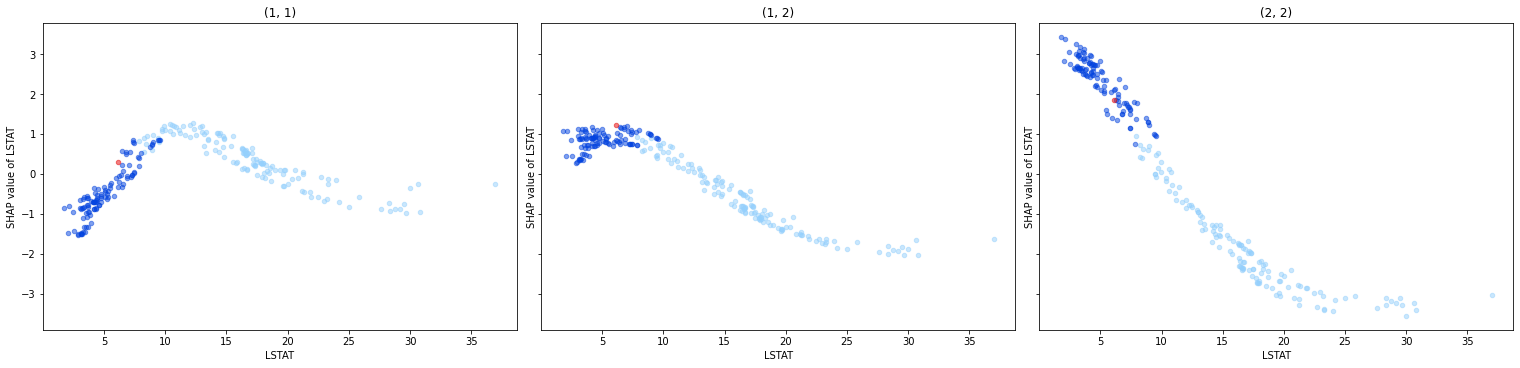

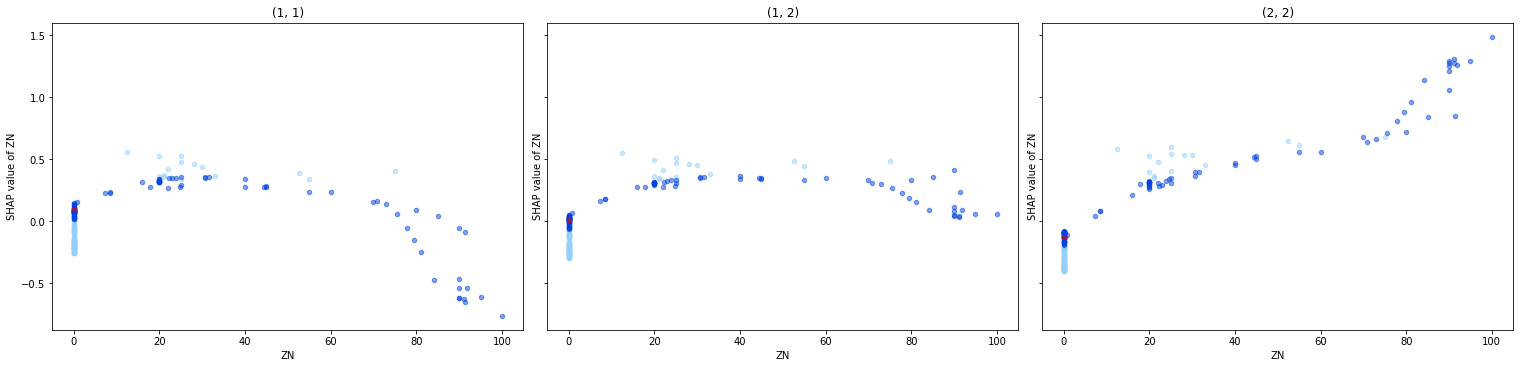

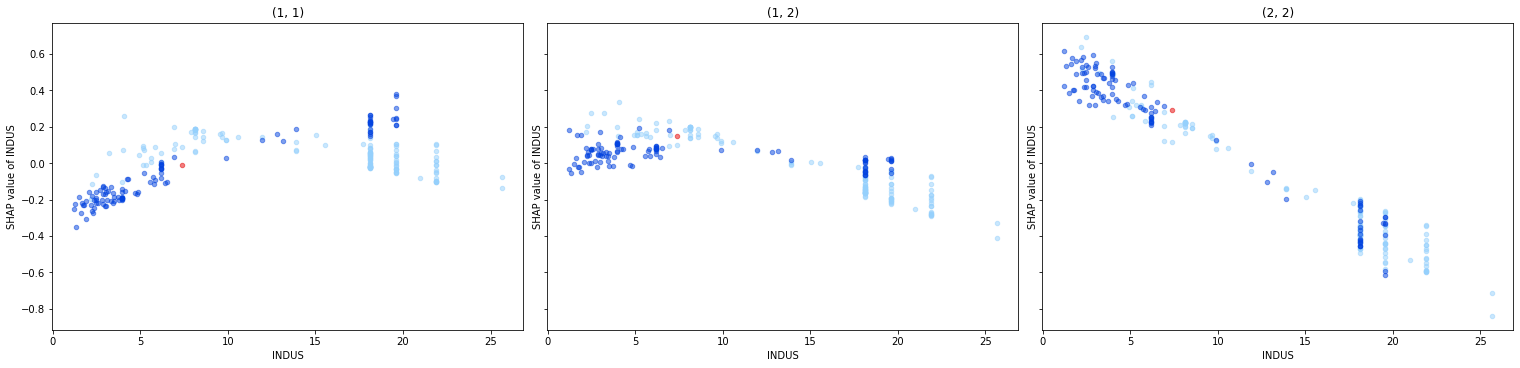

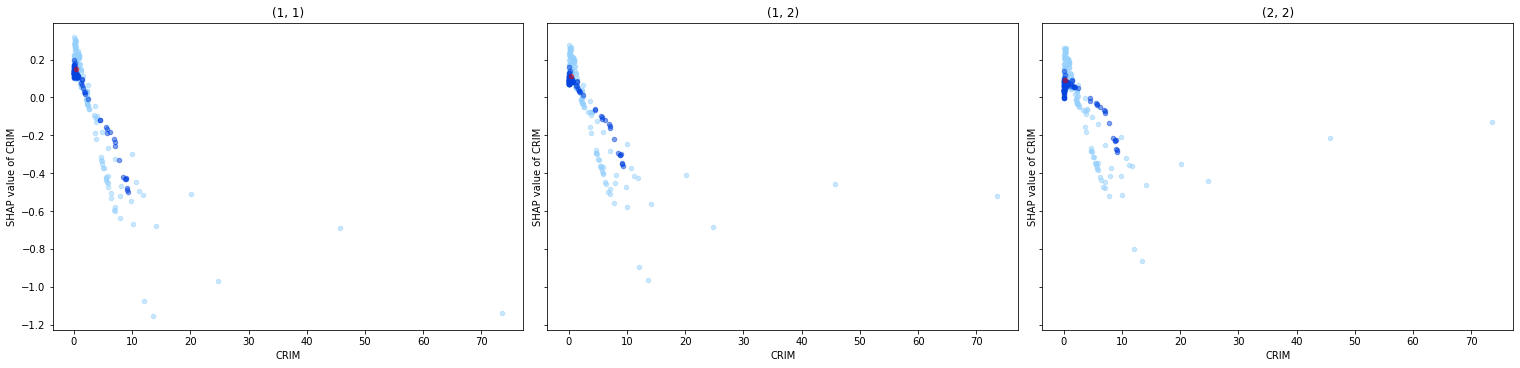

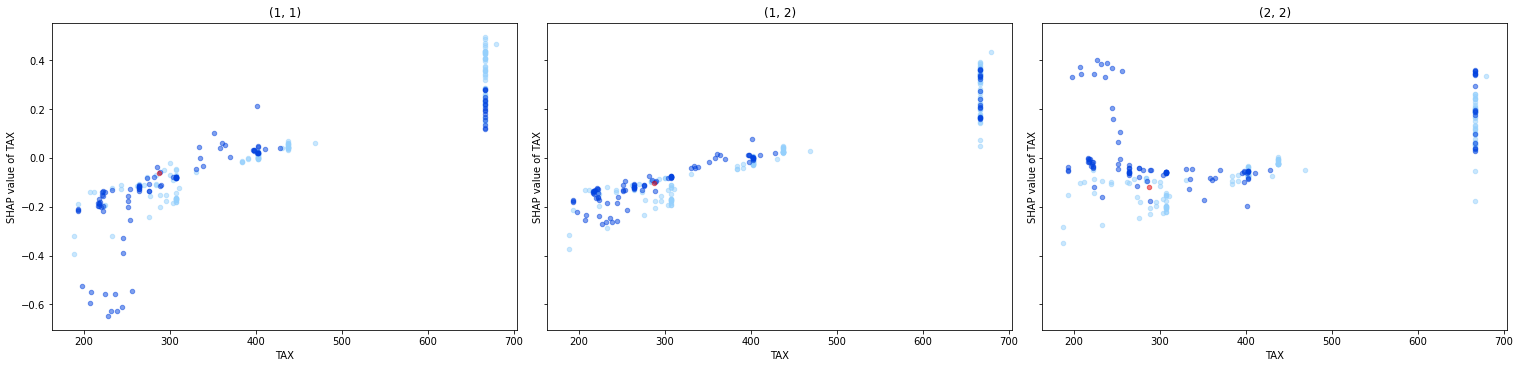

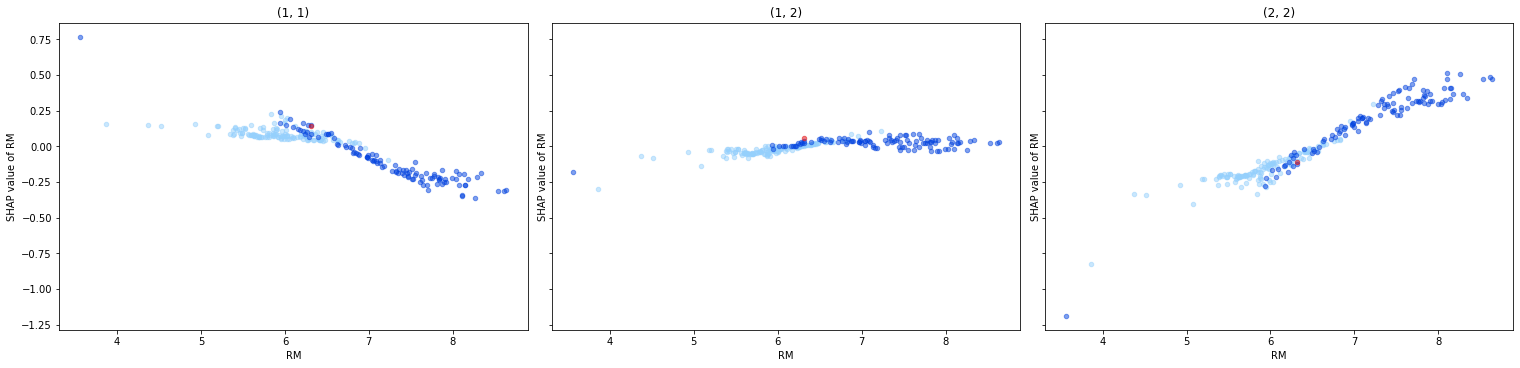

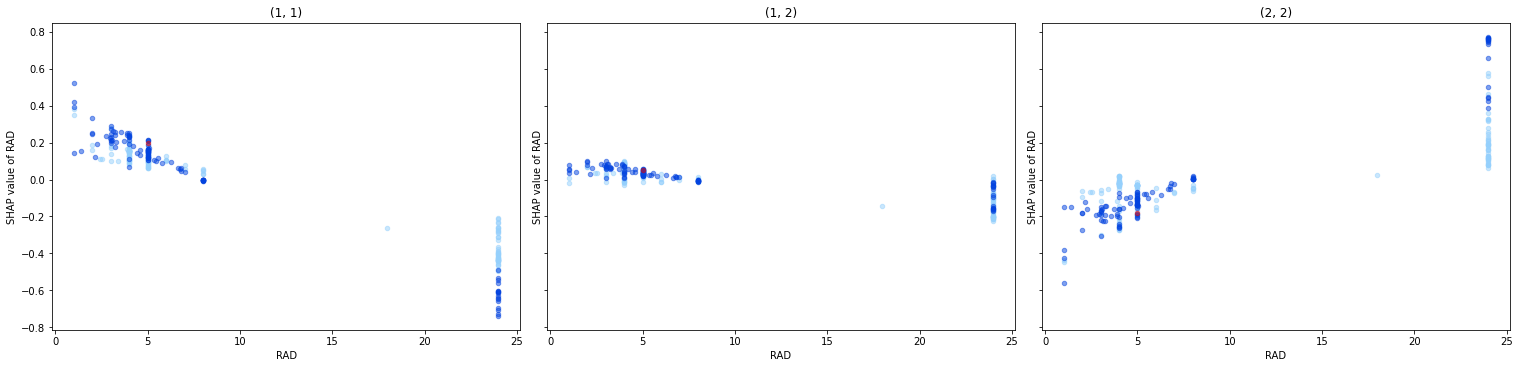

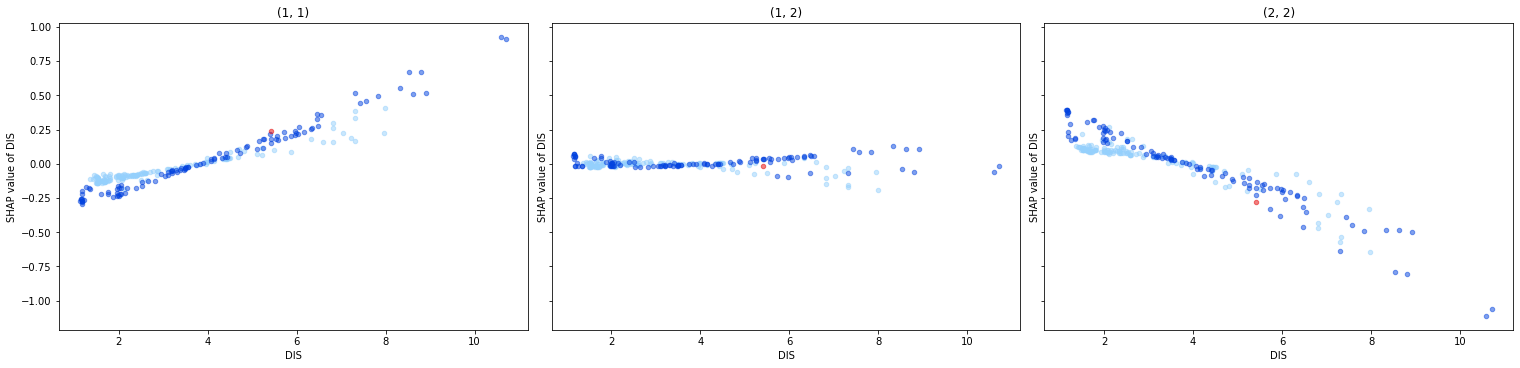

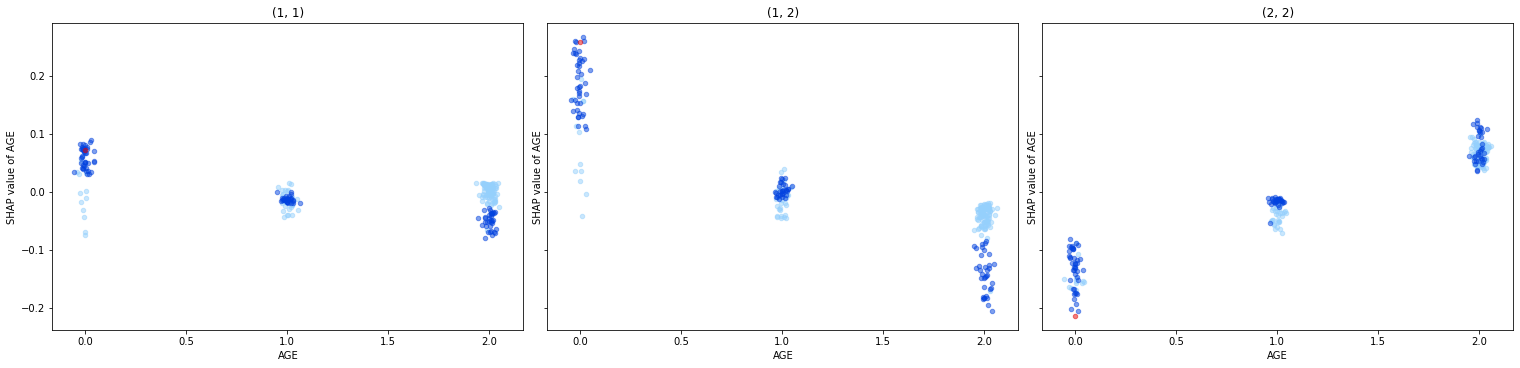

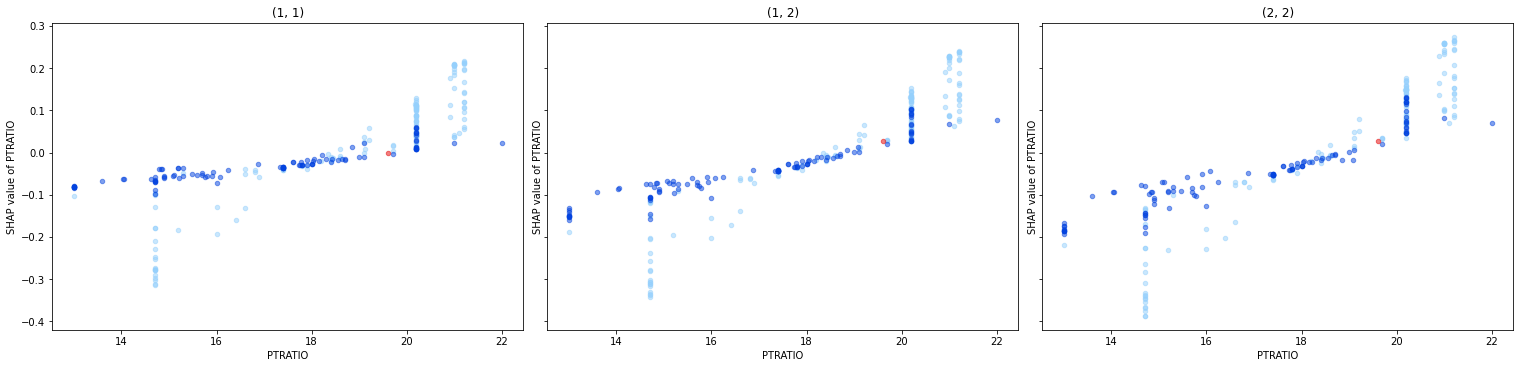

In [39]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [40]:
node.describe_feature('LSTAT')

global   local-all  local-diff
count  246.000000  109.000000        1.00
mean    11.736981    5.077415        6.15
std      7.372550    1.866114         NaN
min      1.763949    1.763949        6.15
25%      5.008267    3.620501        6.15
50%      9.950000    4.540000        6.15
75%     17.091674    6.480000        6.15
max     36.980000    9.530000        6.15

In [41]:
node.test(LSTAT=4.5)

before  after
(1, 2)     1.0    NaN
(2, 2)     NaN    1.0

In [42]:
node.test(LSTAT=6.3)

before  after
(1, 1)     NaN    1.0
(1, 2)     1.0    NaN

In [43]:
node.describe_feature('ZN')

global   local-all  local-diff
count  246.000000  109.000000         1.0
mean    12.841063   24.714692         0.0
std     25.552540   32.713207         NaN
min      0.000000    0.000000         0.0
25%      0.000000    0.000000         0.0
50%      0.000000    8.378774         0.0
75%     20.000000   40.000000         0.0
max    100.000000  100.000000         0.0

In [44]:
node.test(ZN=90)

before  after
(1, 2)     1.0    NaN
(2, 2)     NaN    1.0

In [45]:
node.describe_feature('INDUS')

global   local-all  local-diff
count  246.000000  109.000000        1.00
mean    11.718208    7.586542        7.38
std      7.290396    6.442231         NaN
min      1.210000    1.210000        7.38
25%      4.243588    2.890000        7.38
50%      9.900000    4.216712        7.38
75%     18.100000   12.830000        7.38
max     25.650000   19.580000        7.38

In [46]:
node.test(INDUS=1)

before  after
(1, 2)       1      1

In [47]:
node.test(INDUS=9)

before  after
(1, 1)     NaN    1.0
(1, 2)     1.0    NaN

## Clustering of Class $(2,1)$ SHAP Values

In [48]:
node, Z = make_clustering(comparer, explanations.mclass_diff.log_odds, '(2, 1)', ['(1, 1)', '(2, 1)', '(2, 2)'],
                          categorical_features=categorical_features)

root
(2, 2)    95
(0, 0)    76
(1, 1)    58
(0, 1)    13
(2, 1)     3
(1, 2)     1
dtype: int64


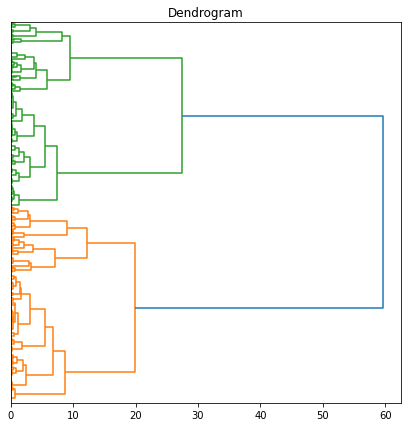

In [49]:
plot_dendrogram(Z)

### Root Node

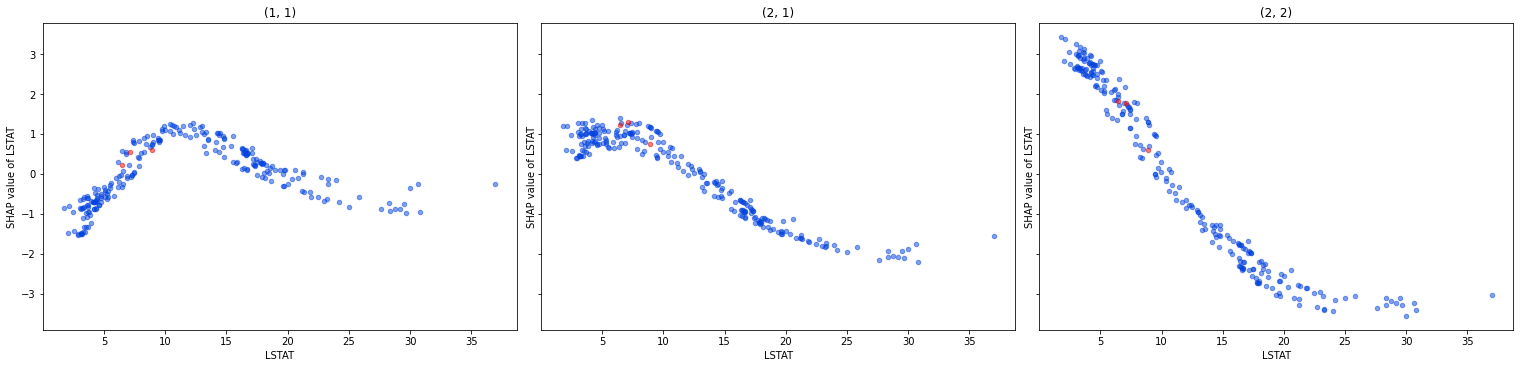

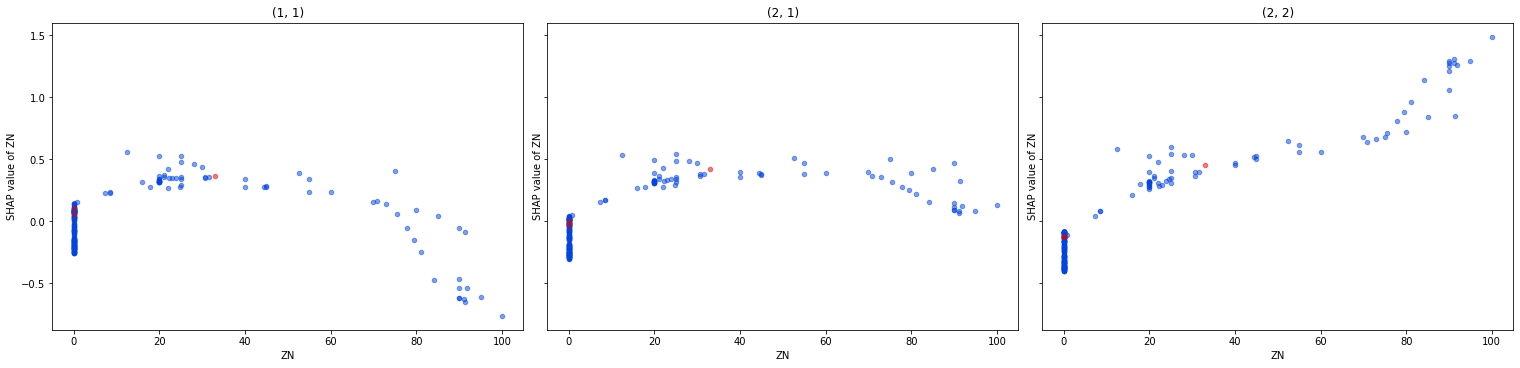

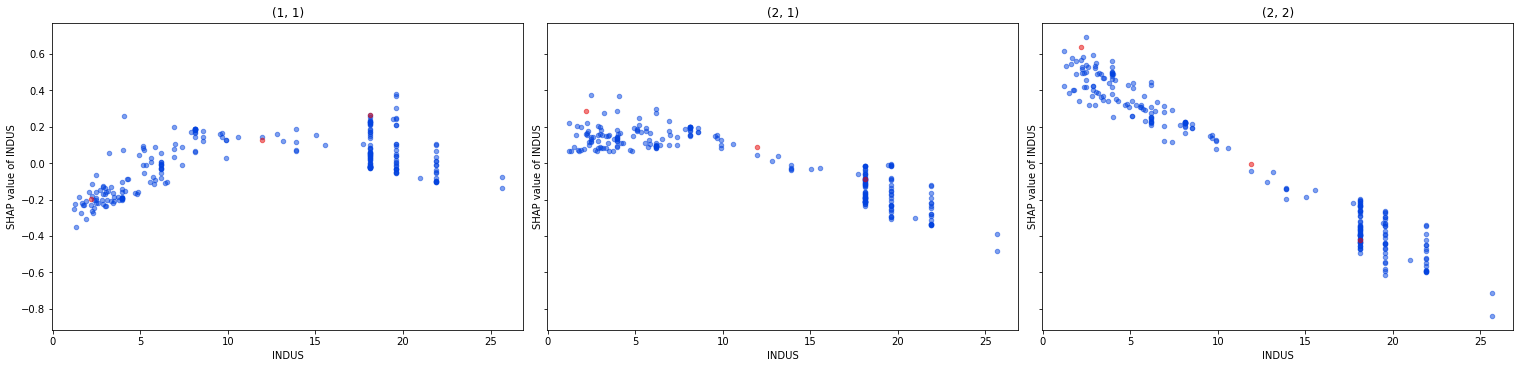

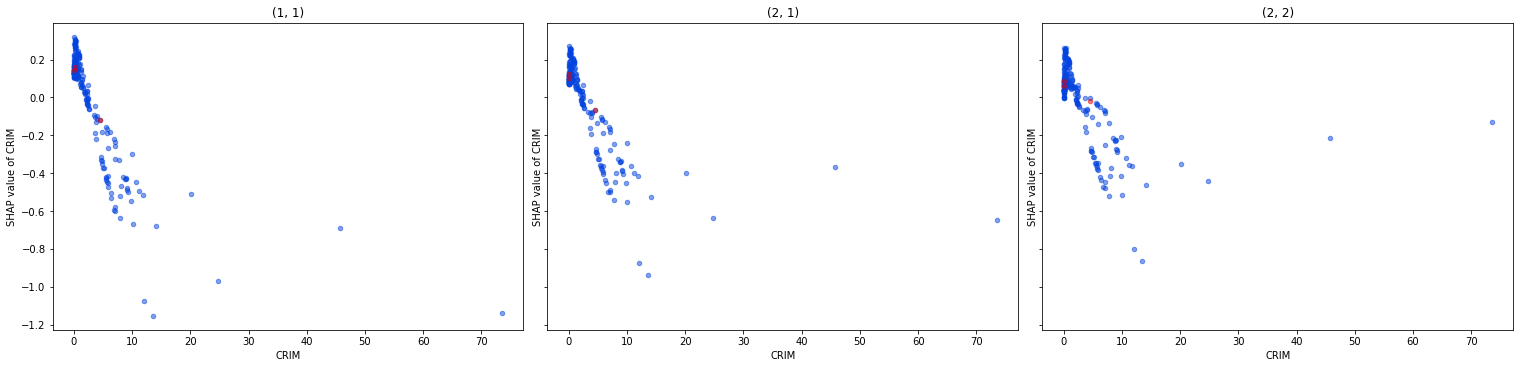

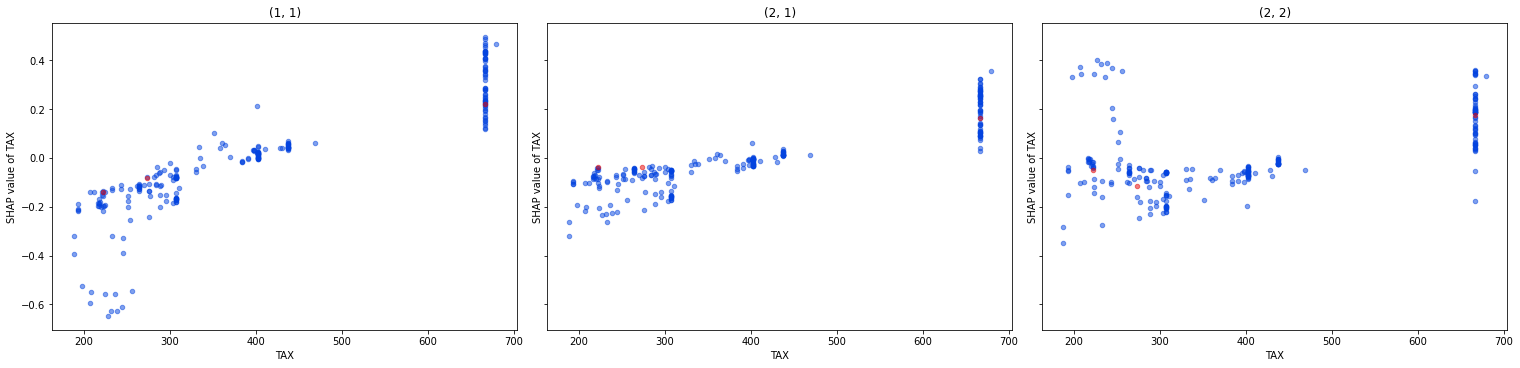

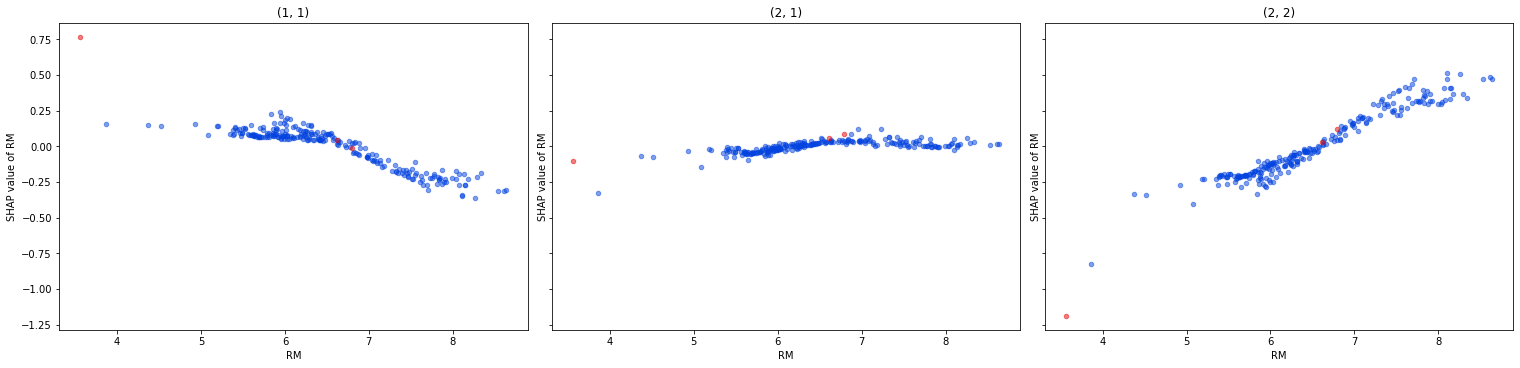

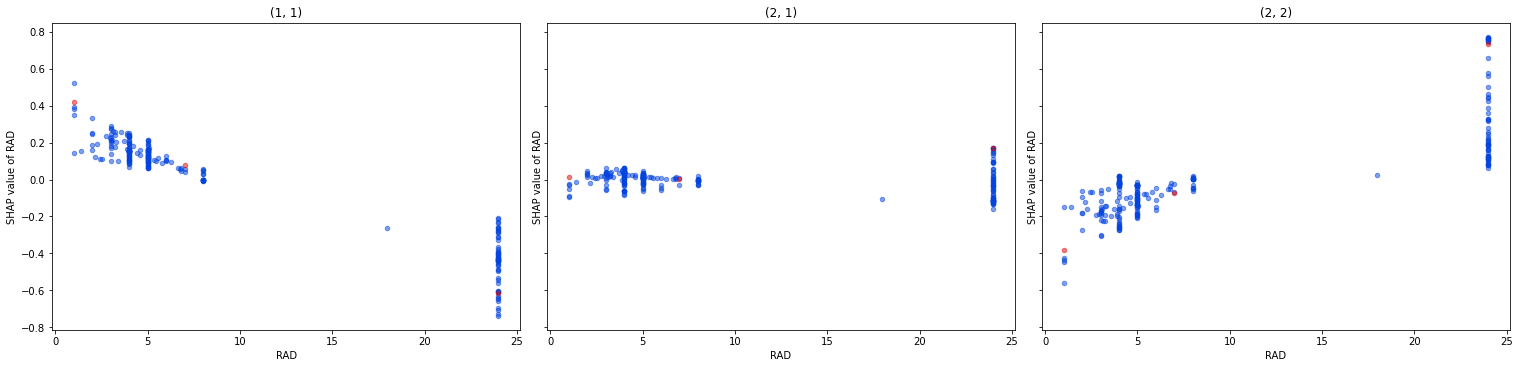

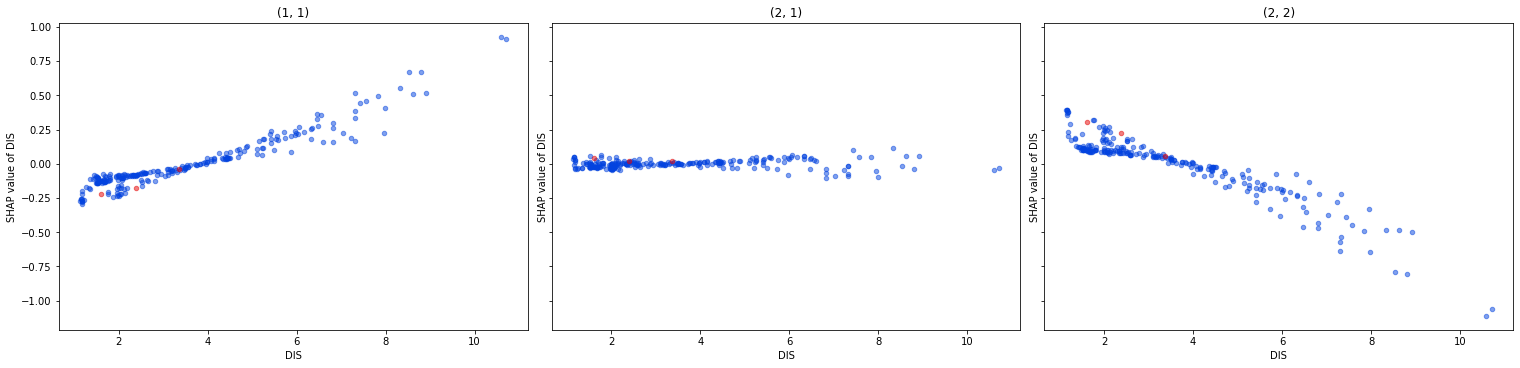

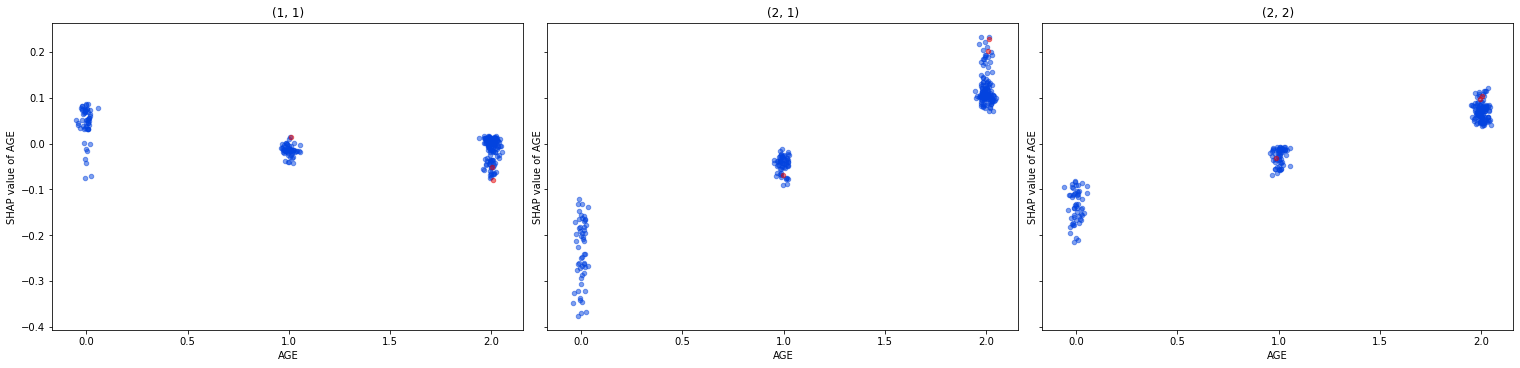

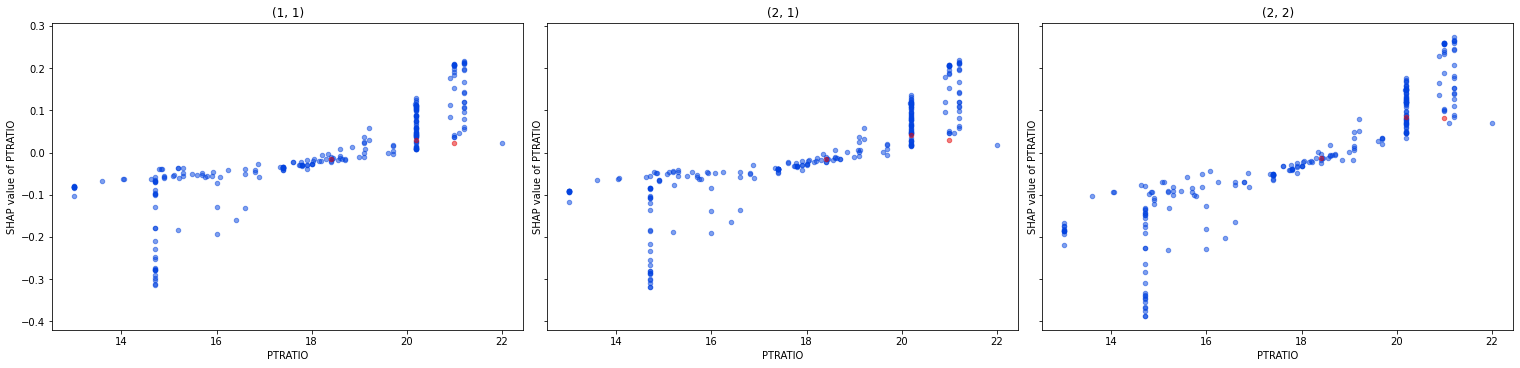

In [50]:
for feature in global_feature_order:
    node.plot_feature(feature, alpha=0.5)

In [51]:
node.describe_feature('LSTAT')

global   local-all  local-diff
count  246.000000  246.000000    3.000000
mean    11.736981   11.736981    7.510000
std      7.372550    7.372550    1.270708
min      1.763949    1.763949    6.480000
25%      5.008267    5.008267    6.800000
50%      9.950000    9.950000    7.120000
75%     17.091674   17.091674    8.025000
max     36.980000   36.980000    8.930000

### Node L

In [53]:
node = node.get_left()

L
(2, 2)    95
(1, 1)    28
(2, 1)     3
(1, 2)     1
dtype: int64


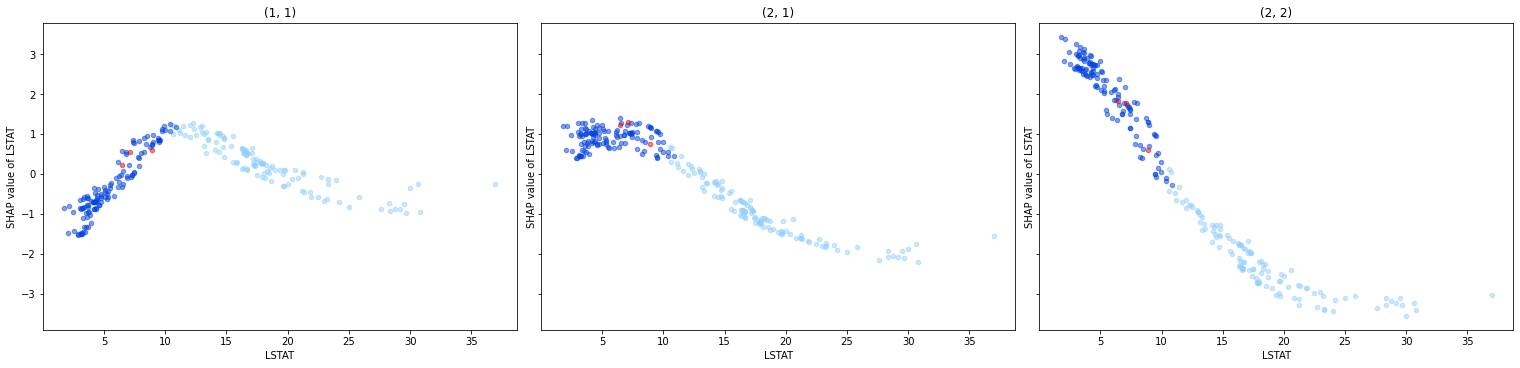

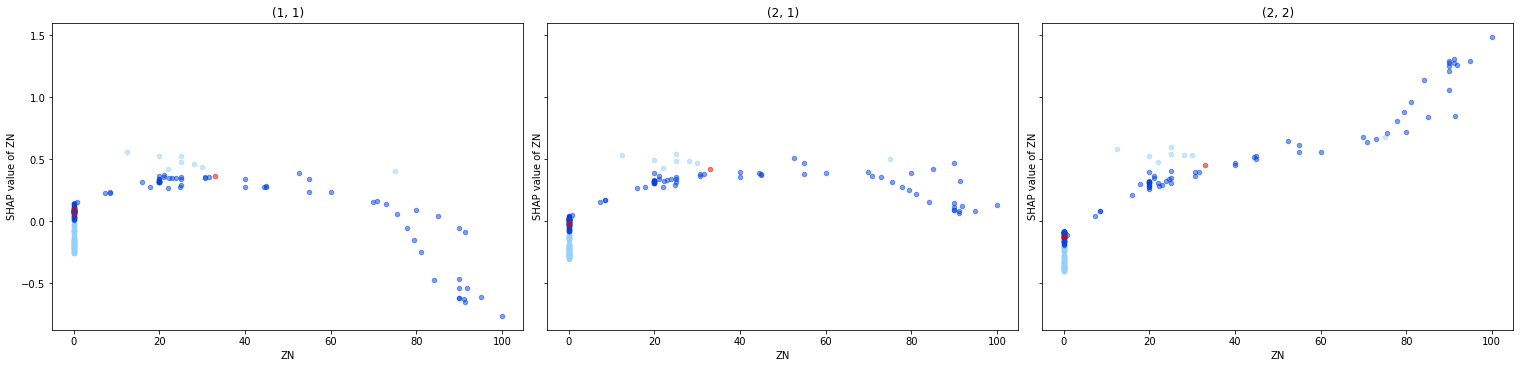

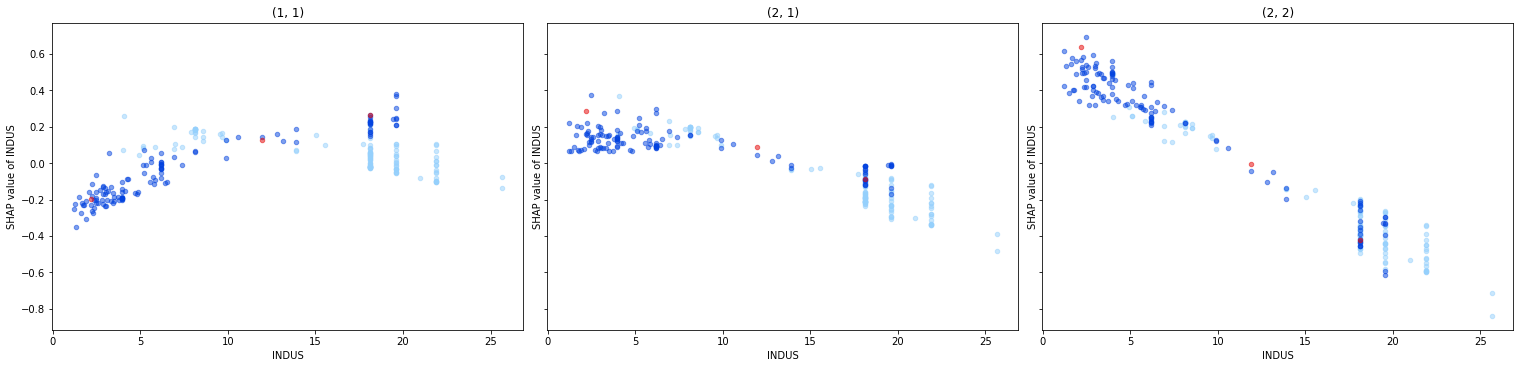

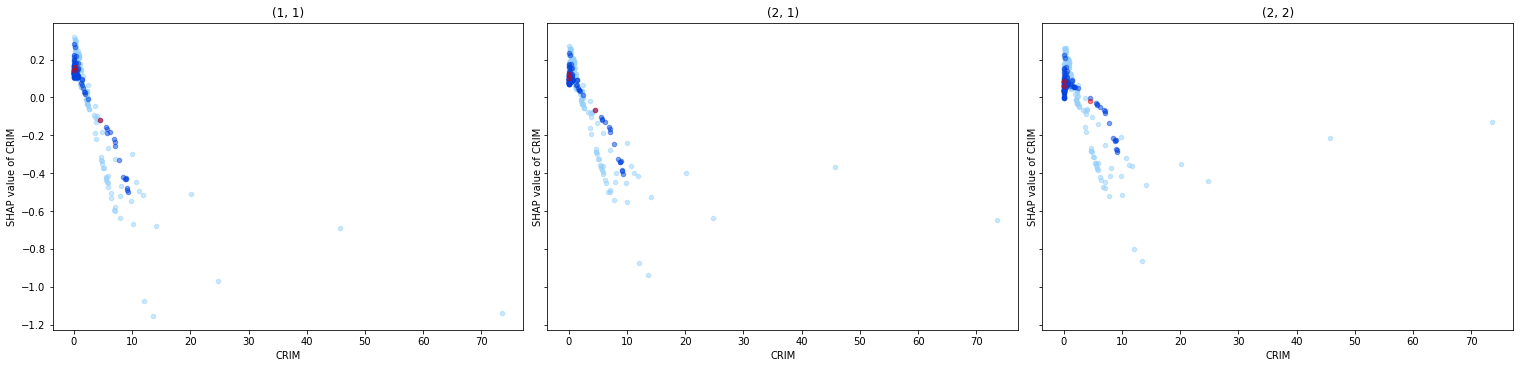

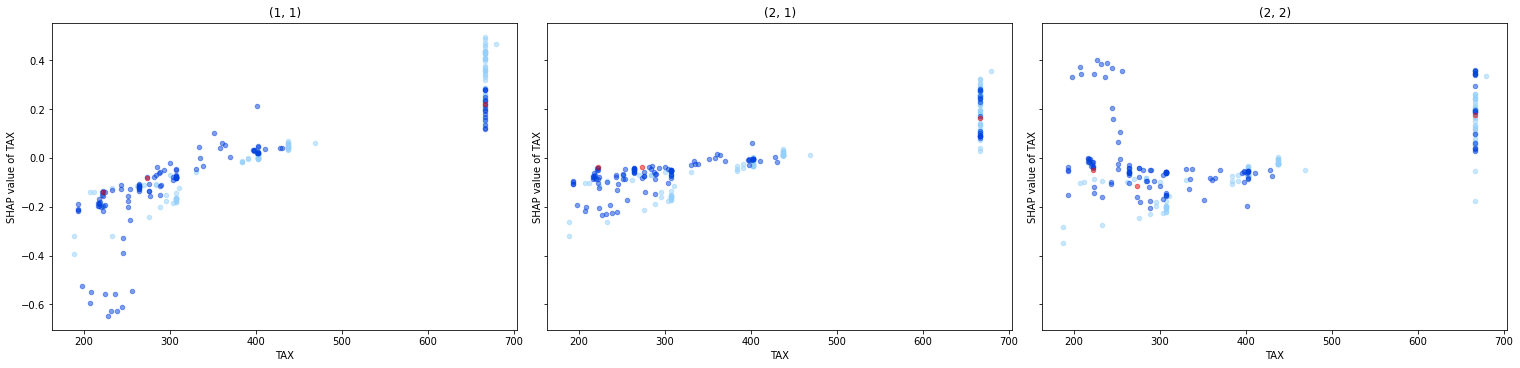

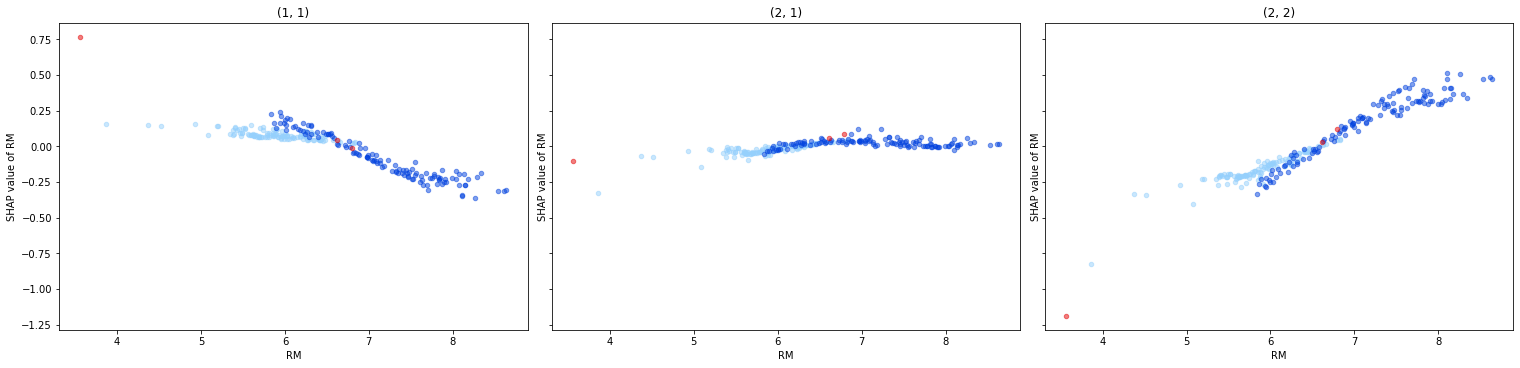

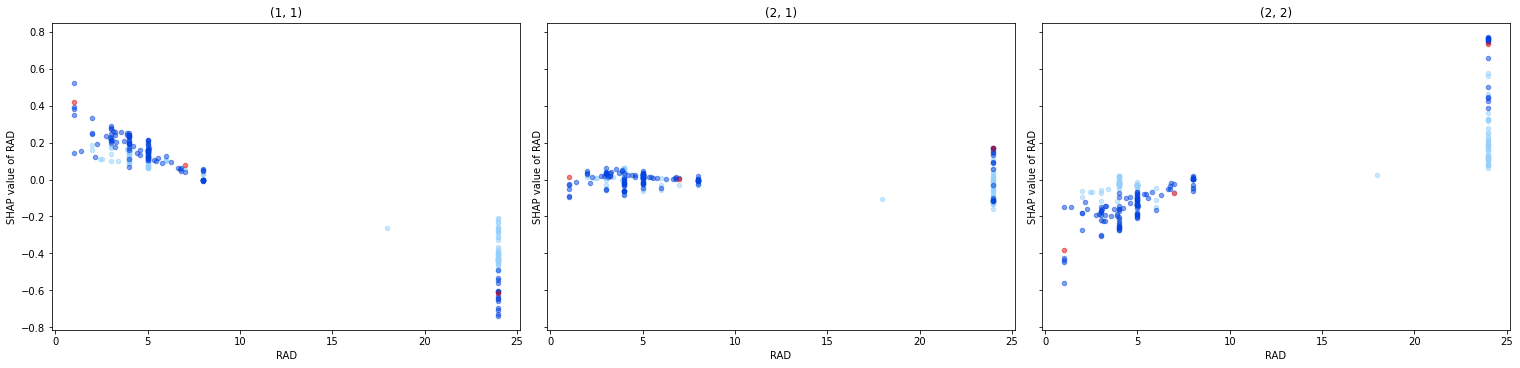

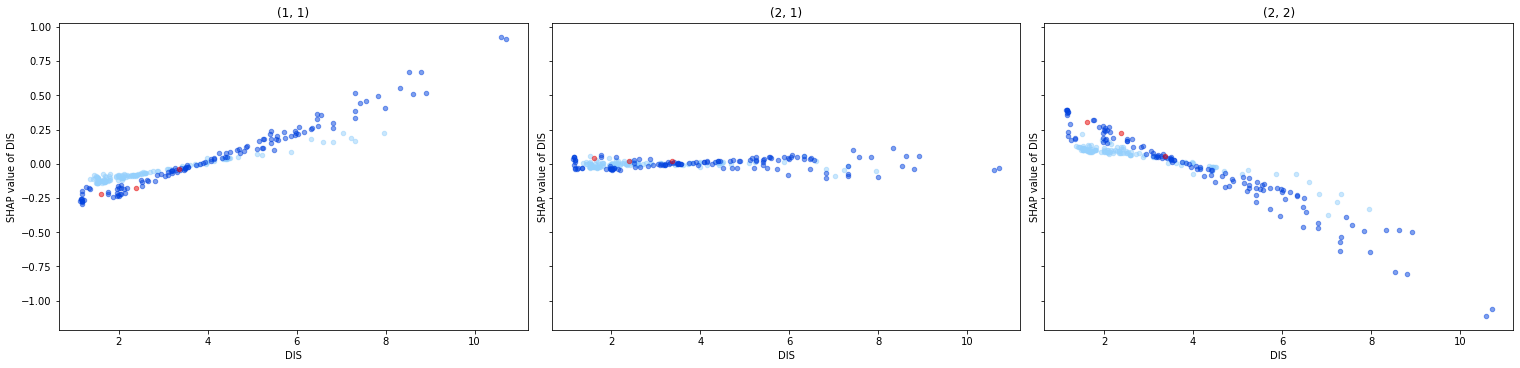

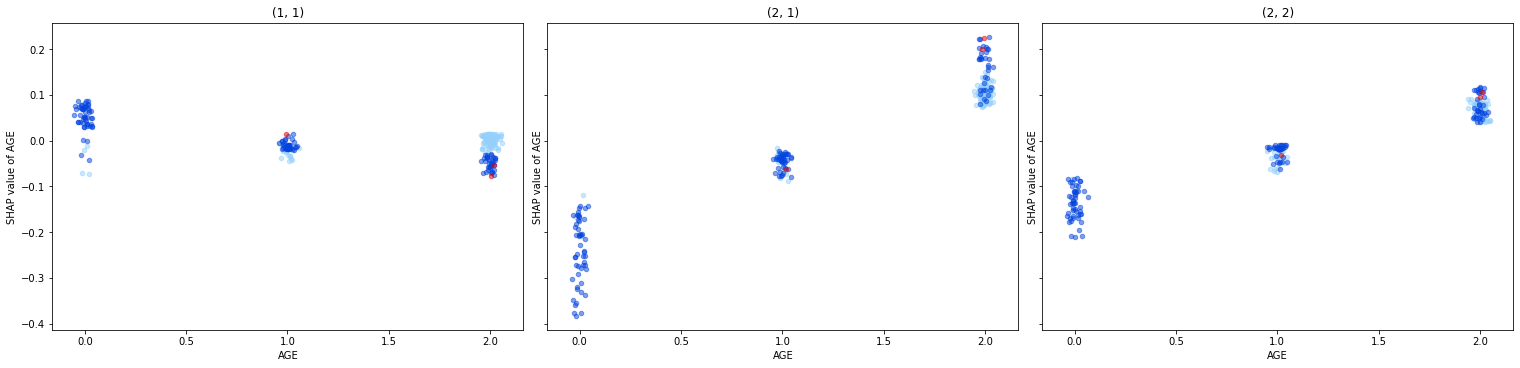

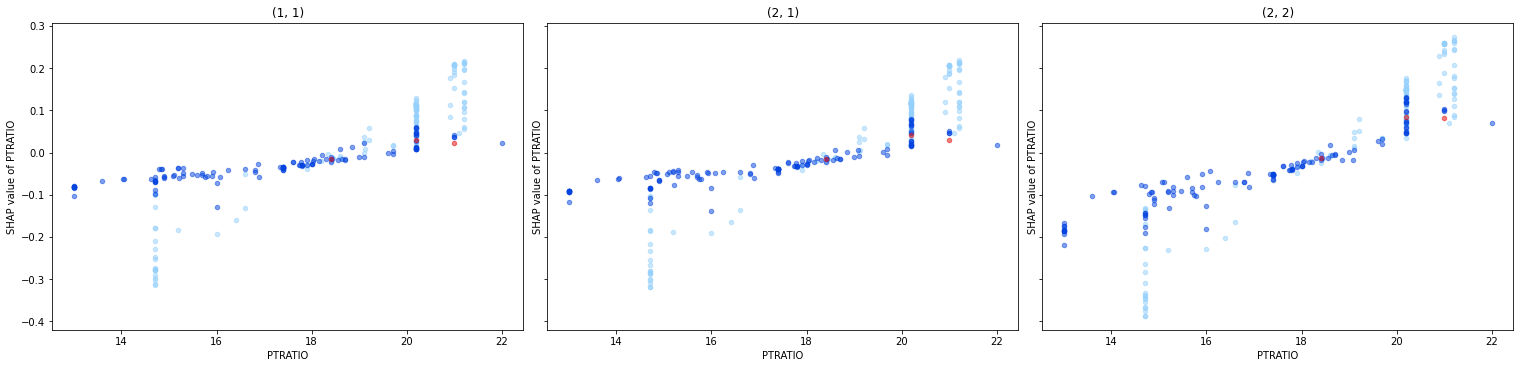

In [54]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [55]:
node.describe_feature('LSTAT')

global   local-all  local-diff
count  246.000000  127.000000    3.000000
mean    11.736981    5.681719    7.510000
std      7.372550    2.304218    1.270708
min      1.763949    1.763949    6.480000
25%      5.008267    3.696082    6.800000
50%      9.950000    5.058243    7.120000
75%     17.091674    7.401020    8.025000
max     36.980000   10.870000    8.930000

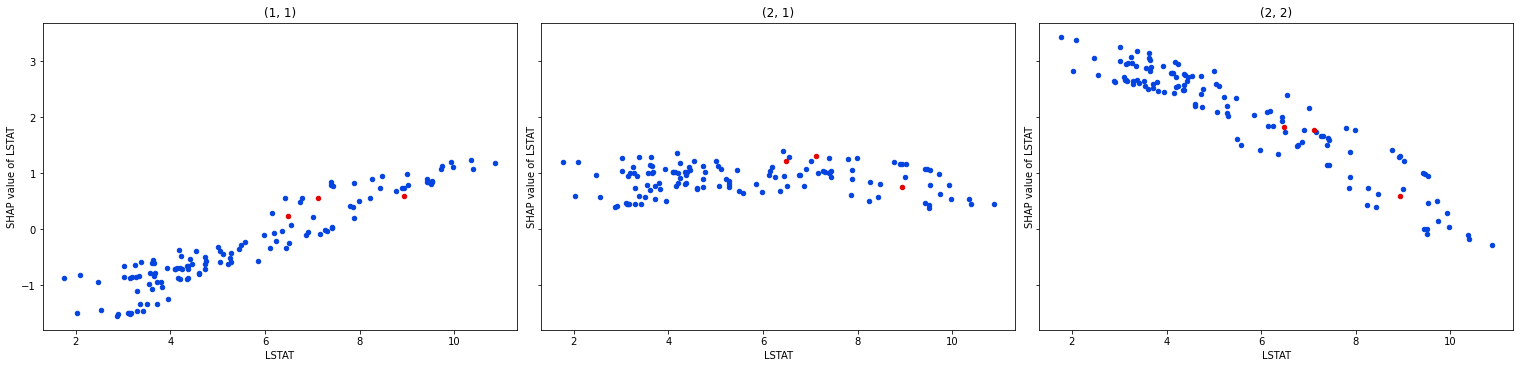

In [56]:
node.plot_feature('LSTAT')

In [57]:
node.test(LSTAT=5.9)

before  after
(2, 1)     3.0    NaN
(2, 2)     NaN    3.0

In [58]:
node.test(LSTAT=9.1)

before  after
(1, 1)     NaN    3.0
(2, 1)     3.0    NaN

In [59]:
node.describe_feature('RM')

global   local-all  local-diff
count  246.000000  127.000000     3.00000
mean     6.511388    7.097899     5.65700
std      0.889747    0.784680     1.81737
min      3.561000    3.561000     3.56100
25%      5.882000    6.523870     5.08850
50%      6.315500    7.100179     6.61600
75%      7.134552    7.697315     6.70500
max      8.638029    8.638029     6.79400

In [60]:
node.test(RM=7.3)

before  after
(2, 1)     3.0    NaN
(2, 2)     NaN    3.0

In [61]:
node.describe_feature('DIS')

global   local-all  local-diff
count  246.000000  127.000000    3.000000
mean     3.501706    4.184753    2.457367
std      2.007156    2.193218    0.880399
min      1.137912    1.137912    1.613200
25%      1.967365    2.294509    2.001050
50%      2.866600    3.838400    2.388900
75%      4.621654    5.577023    2.879450
max     10.710300   10.710300    3.370000

In [62]:
node.test(DIS=4.2)

before  after
(1, 1)     NaN    3.0
(2, 1)     3.0    NaN